In [8]:
%load_ext autoreload
%autoreload 2
%matplotlib inline


import tensorflow as tf
import numpy as np
import trieste
import gpflow
import matplotlib.pyplot as plt


import gym

# env_name = "LunarLander-v2"
# env = gym.make(env_name)

# seed = 1793

# np.random.seed(seed)
# tf.random.set_seed(seed)
# env.seed(seed)

from lunar_lander.lunar_lander import LunarLander
from lunar_lander.controller import demo_heuristic_lander




from mo_penalization import MOLocalPenalizationAcquisitionFunction
from trieste.acquisition.rule import EfficientGlobalOptimization
from trieste.bayesian_optimizer import BayesianOptimizer
from trieste.observer import OBJECTIVE

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [9]:
search_space = trieste.space.Box([0.0] * 12, [1.2] * 12)

In [12]:
for _ in range(10):
    sample_w = search_space.sample(1).numpy()[0]
    demo_heuristic_lander(LunarLander(), sample_w, print_progress=False)

DemoHeuristicResult: reward: -95.88, fuel: 1.83, steps: 82.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: -104.54, fuel: 0.54, steps: 60.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -56.71, fuel: 8.10, steps: 58.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -0.51, fuel: 24.06, steps: 164.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: -156.28, fuel: 7.14, steps: 82.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -107.65, fuel: 0.93, steps: 48.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: 54.31, fuel: 14.70, steps: 84.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: -75.39, fuel: 10.23, steps: 73.0, crashed: True, timeout: Fa

In [48]:
reward_max = 250.0
reward_min = -350.0
fuel_factor = 100.0

N_RUNS = 10

def lander_objective(x):
    # for each point compute average reward and fuel consumed over N_RUNS runs
    all_rewards = []
    all_fuel = []
    for w in x.numpy():
        results = [demo_heuristic_lander(LunarLander(), w) for _ in range(N_RUNS)]
        all_rewards.append([r.total_reward for r in results])
        all_fuel.append([r.total_fuel for r in results])

    rewards_tensor = tf.convert_to_tensor(all_rewards, dtype=tf.float64)
    rewards_mean = tf.reshape(tf.math.reduce_mean(rewards_tensor, axis=1), (-1, 1))
    fuel_tensor = tf.convert_to_tensor(all_fuel, dtype=tf.float64)
    fuel_mean = tf.reshape(tf.math.reduce_mean(fuel_tensor, axis=1), (-1, 1))
    

    # normalizing these values is tricky
    # we want them to be between 0 and 1
    # but we have only rough idea of the min/max ranges
    # reward seems to be between -350 and 250
    # fuel is normally between 0 and 100 (actually in theory it can go to 1000*0.33=330, but this seems to never happen in practice)
    
    rewards_mean = (reward_max - rewards_mean)/(reward_max - reward_min)
    fuel_mean = fuel_mean / fuel_factor
    
    objectives_tensor = tf.concat([rewards_mean, fuel_mean], axis=-1)
    return objectives_tensor


observer = trieste.objectives.utils.mk_observer(lander_objective)

In [31]:
from trieste.models.gpflow import SparseVariational, build_svgp
from trieste.models.interfaces import TrainablePredictJointReparamModelStack
from trieste.data import Dataset

def build_stacked_independent_objectives_model(data, n_obj):
    models = []
    for idx in range(n_obj):
        single_obj_data = Dataset(
            data.query_points, tf.gather(data.observations, [idx], axis=1)
        )
        svgp = build_svgp(initial_data, search_space)
        models.append((SparseVariational(svgp), 1))

    return TrainablePredictJointReparamModelStack(*models)

In [44]:
N_STEPS = 100
num_initial_points = 2 * search_space.dimension

initial_query_points = search_space.sample(num_initial_points)
initial_data = observer(initial_query_points)
model = build_stacked_independent_objectives_model(initial_data, 2)

acq_fn = MOLocalPenalizationAcquisitionFunction().using(OBJECTIVE)
acq_rule = EfficientGlobalOptimization(acq_fn, num_query_points=20)

optimizer = BayesianOptimizer(observer, search_space)
result = optimizer.optimize(N_STEPS, initial_data, model, acq_rule)

DemoHeuristicResult: reward: -84.83, fuel: 3.24, steps: 94.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -84.46, fuel: 4.32, steps: 95.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -79.05, fuel: 3.66, steps: 61.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -104.43, fuel: 0.06, steps: 91.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: -103.56, fuel: 3.93, steps: 90.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -69.54, fuel: 1.86, steps: 47.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -88.40, fuel: 0.66, steps: 92.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: -90.17, fuel: 0.03, steps: 90.0, crashed: True, timeout: Fals

DemoHeuristicResult: reward: 43.30, fuel: 17.40, steps: 138.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: 39.80, fuel: 18.60, steps: 107.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -6.95, fuel: 15.24, steps: 109.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: -21.63, fuel: 16.77, steps: 126.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: 31.93, fuel: 18.06, steps: 130.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -24.46, fuel: 23.10, steps: 139.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: 12.77, fuel: 23.46, steps: 144.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -298.92, fuel: 11.40, steps: 99.0, crashed: True, time

DemoHeuristicResult: reward: -98.61, fuel: 24.81, steps: 198.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: -289.96, fuel: 13.50, steps: 63.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -33.55, fuel: 4.02, steps: 50.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: -29.26, fuel: 3.36, steps: 53.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: -179.24, fuel: 4.11, steps: 89.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -87.84, fuel: 3.42, steps: 64.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -196.01, fuel: 4.23, steps: 85.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -79.66, fuel: 3.45, steps: 54.0, crashed: True, timeout: F

DemoHeuristicResult: reward: -23.66, fuel: 24.03, steps: 178.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -59.73, fuel: 13.38, steps: 102.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -151.46, fuel: 14.10, steps: 87.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -335.65, fuel: 7.47, steps: 85.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -248.95, fuel: 0.00, steps: 88.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: 46.51, fuel: 0.00, steps: 71.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -138.35, fuel: 0.00, steps: 52.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -154.90, fuel: 0.30, steps: 57.0, crashed: True, time

DemoHeuristicResult: reward: -321.79, fuel: 14.10, steps: 105.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -304.74, fuel: 10.20, steps: 71.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -275.49, fuel: 12.99, steps: 112.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -22.69, fuel: 13.95, steps: 126.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -337.90, fuel: 11.37, steps: 76.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -262.54, fuel: 14.40, steps: 67.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -90.04, fuel: 14.70, steps: 111.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -277.22, fuel: 5.40, steps: 94.0, crashed: Tr

DemoHeuristicResult: reward: -104.02, fuel: 3.93, steps: 77.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -76.65, fuel: 3.03, steps: 80.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: 45.50, fuel: 22.86, steps: 123.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: -12.19, fuel: 15.66, steps: 116.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: 56.03, fuel: 22.95, steps: 118.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: 26.60, fuel: 18.99, steps: 106.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: 19.85, fuel: 24.72, steps: 144.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: 33.27, fuel: 17.10, steps: 100.0, crashed: True, timeout: 

DemoHeuristicResult: reward: -298.51, fuel: 25.17, steps: 175.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -46.00, fuel: 19.23, steps: 153.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: 191.53, fuel: 31.68, steps: 335.0, crashed: False, timeout: False, is_in_helipad: True, success: True
DemoHeuristicResult: reward: -70.44, fuel: 0.30, steps: 101.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -121.33, fuel: 0.75, steps: 83.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -98.28, fuel: 0.18, steps: 68.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -94.32, fuel: 0.60, steps: 56.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: -132.02, fuel: 0.45, steps: 94.0, crashed: True, timeo

DemoHeuristicResult: reward: 276.52, fuel: 51.00, steps: 373.0, crashed: False, timeout: False, is_in_helipad: True, success: True
DemoHeuristicResult: reward: 270.90, fuel: 33.30, steps: 343.0, crashed: False, timeout: False, is_in_helipad: True, success: True
DemoHeuristicResult: reward: -35.57, fuel: 12.90, steps: 82.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -239.23, fuel: 18.00, steps: 115.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -238.34, fuel: 18.60, steps: 143.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -314.04, fuel: 15.30, steps: 90.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -287.53, fuel: 11.40, steps: 70.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -191.55, fuel: 12.30, steps: 105.0, crashed: Tru

DemoHeuristicResult: reward: -115.71, fuel: 0.30, steps: 55.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -175.06, fuel: 0.60, steps: 91.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -138.78, fuel: 0.60, steps: 83.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -71.72, fuel: 0.30, steps: 54.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -208.89, fuel: 0.60, steps: 97.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -112.31, fuel: 0.60, steps: 49.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -158.55, fuel: 0.60, steps: 51.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -134.15, fuel: 0.60, steps: 71.0, crashed: True, timeou

DemoHeuristicResult: reward: 47.06, fuel: 106.74, steps: 777.0, crashed: False, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: 15.83, fuel: 94.29, steps: 1001.0, crashed: False, timeout: True, is_in_helipad: False, success: False
DemoHeuristicResult: reward: 220.44, fuel: 83.49, steps: 515.0, crashed: False, timeout: False, is_in_helipad: True, success: True
DemoHeuristicResult: reward: 49.26, fuel: 91.32, steps: 1001.0, crashed: False, timeout: True, is_in_helipad: False, success: False
DemoHeuristicResult: reward: 35.53, fuel: 17.70, steps: 104.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -31.41, fuel: 94.44, steps: 511.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: 237.71, fuel: 83.19, steps: 478.0, crashed: False, timeout: False, is_in_helipad: True, success: True
DemoHeuristicResult: reward: -178.49, fuel: 0.30, steps: 65.0, crashed: True, t

DemoHeuristicResult: reward: -246.02, fuel: 23.10, steps: 115.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: 21.07, fuel: 14.70, steps: 92.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: -280.36, fuel: 11.70, steps: 108.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -267.04, fuel: 20.10, steps: 102.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -288.75, fuel: 14.10, steps: 74.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -398.95, fuel: 14.10, steps: 123.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -277.41, fuel: 17.70, steps: 78.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -7.76, fuel: 16.20, steps: 108.0, crashed: Tru

DemoHeuristicResult: reward: -197.59, fuel: 167.34, steps: 1001.0, crashed: False, timeout: True, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -93.31, fuel: 171.93, steps: 1001.0, crashed: False, timeout: True, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -170.31, fuel: 18.84, steps: 95.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -116.36, fuel: 163.53, steps: 1001.0, crashed: False, timeout: True, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -63.08, fuel: 23.91, steps: 144.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -175.34, fuel: 16.62, steps: 90.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -95.34, fuel: 0.00, steps: 48.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: -132.02, fuel: 0.00, steps: 93.0, crashed:

DemoHeuristicResult: reward: -201.75, fuel: 182.58, steps: 1001.0, crashed: False, timeout: True, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -123.37, fuel: 186.36, steps: 1001.0, crashed: False, timeout: True, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -146.07, fuel: 0.30, steps: 59.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -115.98, fuel: 0.00, steps: 53.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -156.81, fuel: 0.12, steps: 68.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -161.67, fuel: 0.15, steps: 62.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -152.14, fuel: 0.39, steps: 61.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -127.97, fuel: 0.00, steps: 76.0, crashed: Tru

DemoHeuristicResult: reward: -44.18, fuel: 55.65, steps: 504.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: 181.33, fuel: 49.74, steps: 451.0, crashed: False, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: 34.06, fuel: 65.25, steps: 1001.0, crashed: False, timeout: True, is_in_helipad: False, success: False
DemoHeuristicResult: reward: 3.03, fuel: 45.30, steps: 281.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: 36.67, fuel: 46.53, steps: 253.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: 41.00, fuel: 47.31, steps: 294.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: 21.79, fuel: 56.40, steps: 350.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -227.85, fuel: 52.32, steps: 381.0, crashed: True, tim

DemoHeuristicResult: reward: -154.44, fuel: 0.00, steps: 60.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -151.49, fuel: 0.00, steps: 63.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -250.08, fuel: 0.00, steps: 91.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -162.51, fuel: 0.00, steps: 71.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -159.30, fuel: 0.00, steps: 49.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: 55.87, fuel: 19.62, steps: 105.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: 250.23, fuel: 23.40, steps: 220.0, crashed: False, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -83.86, fuel: 17.58, steps: 99.0, crashed: True, time

DemoHeuristicResult: reward: -75.79, fuel: 150.51, steps: 1001.0, crashed: False, timeout: True, is_in_helipad: False, success: False
DemoHeuristicResult: reward: 12.96, fuel: 11.40, steps: 74.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: -121.99, fuel: 0.30, steps: 71.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: -108.85, fuel: 0.30, steps: 54.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: 10.05, fuel: 0.30, steps: 67.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -245.51, fuel: 0.45, steps: 104.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -149.24, fuel: 0.30, steps: 60.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -150.53, fuel: 0.60, steps: 55.0, crashed: True, timeout

DemoHeuristicResult: reward: -5.02, fuel: 0.42, steps: 84.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -308.12, fuel: 15.60, steps: 73.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -294.73, fuel: 14.70, steps: 63.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -489.56, fuel: 45.12, steps: 253.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -326.35, fuel: 14.40, steps: 59.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -330.92, fuel: 24.90, steps: 147.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -262.23, fuel: 21.30, steps: 135.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -556.04, fuel: 46.56, steps: 285.0, crashed: Tr

DemoHeuristicResult: reward: -161.42, fuel: 49.08, steps: 268.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -110.23, fuel: 17.55, steps: 121.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -181.98, fuel: 176.67, steps: 1001.0, crashed: False, timeout: True, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -113.56, fuel: 43.50, steps: 257.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -48.43, fuel: 18.06, steps: 105.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -275.15, fuel: 29.70, steps: 155.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -335.58, fuel: 10.20, steps: 72.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -267.65, fuel: 22.80, steps: 120.0, cras

DemoHeuristicResult: reward: -147.81, fuel: 172.68, steps: 1001.0, crashed: False, timeout: True, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -338.37, fuel: 8.34, steps: 71.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: -111.77, fuel: 0.03, steps: 52.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: -149.03, fuel: 0.03, steps: 59.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -164.83, fuel: 0.06, steps: 66.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -257.33, fuel: 0.00, steps: 84.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -199.00, fuel: 0.03, steps: 104.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -122.74, fuel: 0.03, steps: 55.0, crashed: True, ti

DemoHeuristicResult: reward: 45.12, fuel: 21.75, steps: 129.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: 14.99, fuel: 25.83, steps: 131.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -6.73, fuel: 21.96, steps: 155.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -10.66, fuel: 21.54, steps: 146.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: 46.52, fuel: 22.20, steps: 131.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: 51.78, fuel: 21.09, steps: 120.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: 80.50, fuel: 24.15, steps: 130.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: 62.60, fuel: 21.66, steps: 132.0, crashed: True, timeout:

DemoHeuristicResult: reward: -170.14, fuel: 61.47, steps: 518.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: 93.19, fuel: 29.10, steps: 192.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: 218.06, fuel: 61.65, steps: 589.0, crashed: False, timeout: False, is_in_helipad: True, success: True
DemoHeuristicResult: reward: 60.95, fuel: 23.52, steps: 154.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: 47.37, fuel: 48.12, steps: 263.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: 150.75, fuel: 63.72, steps: 638.0, crashed: False, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: 217.51, fuel: 62.01, steps: 624.0, crashed: False, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: 19.59, fuel: 56.79, steps: 324.0, crashed: True, t

DemoHeuristicResult: reward: 58.37, fuel: 26.49, steps: 172.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: 76.26, fuel: 25.53, steps: 176.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: 11.20, fuel: 16.23, steps: 118.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: 62.36, fuel: 25.80, steps: 167.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: -37.17, fuel: 12.54, steps: 85.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: 49.34, fuel: 23.13, steps: 123.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: 52.82, fuel: 21.54, steps: 124.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: 110.43, fuel: 26.82, steps: 138.0, crashed: True, timeout: F

DemoHeuristicResult: reward: -74.64, fuel: 187.17, steps: 1001.0, crashed: False, timeout: True, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -155.28, fuel: 181.77, steps: 1001.0, crashed: False, timeout: True, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -175.27, fuel: 187.98, steps: 1001.0, crashed: False, timeout: True, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -123.62, fuel: 182.85, steps: 1001.0, crashed: False, timeout: True, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -105.88, fuel: 187.44, steps: 1001.0, crashed: False, timeout: True, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -152.07, fuel: 189.33, steps: 1001.0, crashed: False, timeout: True, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -87.03, fuel: 187.17, steps: 1001.0, crashed: False, timeout: True, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -66.37, fuel: 183.12, steps:

DemoHeuristicResult: reward: -376.99, fuel: 36.60, steps: 175.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: 52.87, fuel: 0.00, steps: 71.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -198.01, fuel: 0.00, steps: 61.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -138.08, fuel: 0.00, steps: 89.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -138.53, fuel: 0.00, steps: 67.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: -198.46, fuel: 0.00, steps: 65.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -134.60, fuel: 0.00, steps: 63.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -120.80, fuel: 0.00, steps: 55.0, crashed: True, timeou

DemoHeuristicResult: reward: 32.95, fuel: 24.60, steps: 134.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: 62.01, fuel: 25.35, steps: 176.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: -90.09, fuel: 22.29, steps: 169.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: 29.85, fuel: 13.14, steps: 114.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: 48.20, fuel: 11.85, steps: 107.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: 4.41, fuel: 12.66, steps: 98.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: -106.20, fuel: 10.14, steps: 86.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: 11.19, fuel: 12.78, steps: 102.0, crashed: True, timeout: 

DemoHeuristicResult: reward: -24.80, fuel: 8.13, steps: 100.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: -1.54, fuel: 7.26, steps: 53.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: 0.25, fuel: 9.42, steps: 107.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: -40.27, fuel: 7.11, steps: 57.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: 9.68, fuel: 6.93, steps: 69.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: 45.68, fuel: 31.80, steps: 169.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: 50.17, fuel: 33.63, steps: 221.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: 257.58, fuel: 35.22, steps: 328.0, crashed: False, timeout: False, i

DemoHeuristicResult: reward: -54.77, fuel: 12.96, steps: 94.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: 81.46, fuel: 26.37, steps: 150.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: 210.67, fuel: 67.17, steps: 506.0, crashed: False, timeout: False, is_in_helipad: True, success: True
DemoHeuristicResult: reward: -136.64, fuel: 75.57, steps: 601.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: 221.96, fuel: 66.00, steps: 554.0, crashed: False, timeout: False, is_in_helipad: True, success: True
DemoHeuristicResult: reward: 6.78, fuel: 46.56, steps: 1001.0, crashed: False, timeout: True, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -269.91, fuel: 66.06, steps: 574.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: 184.16, fuel: 64.98, steps: 474.0, crashed: False, 

DemoHeuristicResult: reward: 11.03, fuel: 16.77, steps: 118.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: 46.27, fuel: 22.11, steps: 152.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: 83.85, fuel: 22.05, steps: 105.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: 20.94, fuel: 20.61, steps: 129.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: -66.52, fuel: 9.06, steps: 77.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: -104.67, fuel: 8.52, steps: 59.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -39.68, fuel: 12.00, steps: 112.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: -224.68, fuel: 8.22, steps: 85.0, crashed: True, timeout: F

DemoHeuristicResult: reward: 296.58, fuel: 49.32, steps: 379.0, crashed: False, timeout: False, is_in_helipad: True, success: True
DemoHeuristicResult: reward: 235.29, fuel: 71.58, steps: 627.0, crashed: False, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: 247.93, fuel: 59.25, steps: 367.0, crashed: False, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: 167.61, fuel: 68.43, steps: 559.0, crashed: False, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: 204.43, fuel: 67.41, steps: 439.0, crashed: False, timeout: False, is_in_helipad: True, success: True
DemoHeuristicResult: reward: -2.60, fuel: 74.40, steps: 431.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: 267.39, fuel: 50.55, steps: 355.0, crashed: False, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: 225.75, fuel: 70.35, steps: 462.0, crashed: Fa

DemoHeuristicResult: reward: -86.50, fuel: 0.33, steps: 88.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: -82.75, fuel: 0.36, steps: 91.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: -107.93, fuel: 0.03, steps: 63.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: -112.18, fuel: 0.60, steps: 86.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -138.09, fuel: 0.99, steps: 83.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -125.16, fuel: 0.81, steps: 80.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: -132.34, fuel: 2.46, steps: 85.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -88.65, fuel: 0.93, steps: 49.0, crashed: True, timeout: Fal

DemoHeuristicResult: reward: -62.04, fuel: 5.67, steps: 63.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -109.34, fuel: 7.44, steps: 95.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: 19.95, fuel: 14.94, steps: 120.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: 6.10, fuel: 13.32, steps: 93.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: 5.13, fuel: 12.84, steps: 86.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: -27.05, fuel: 11.16, steps: 66.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: -18.77, fuel: 12.72, steps: 100.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: 18.93, fuel: 13.80, steps: 82.0, crashed: True, timeout: False,

DemoHeuristicResult: reward: 2.31, fuel: 19.23, steps: 128.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: 54.60, fuel: 18.42, steps: 101.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: 36.32, fuel: 19.14, steps: 116.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: 64.28, fuel: 18.12, steps: 100.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: 28.71, fuel: 18.93, steps: 127.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: 11.18, fuel: 16.08, steps: 86.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: 31.42, fuel: 19.35, steps: 114.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: 15.22, fuel: 17.58, steps: 118.0, crashed: True, timeout: Fals

DemoHeuristicResult: reward: -51.19, fuel: 149.91, steps: 1001.0, crashed: False, timeout: True, is_in_helipad: False, success: False
DemoHeuristicResult: reward: 192.35, fuel: 74.91, steps: 541.0, crashed: False, timeout: False, is_in_helipad: True, success: True
DemoHeuristicResult: reward: 196.60, fuel: 76.41, steps: 515.0, crashed: False, timeout: False, is_in_helipad: True, success: True
DemoHeuristicResult: reward: -55.71, fuel: 156.87, steps: 1001.0, crashed: False, timeout: True, is_in_helipad: False, success: False
DemoHeuristicResult: reward: 227.16, fuel: 93.84, steps: 664.0, crashed: False, timeout: False, is_in_helipad: True, success: True
DemoHeuristicResult: reward: 281.90, fuel: 87.15, steps: 561.0, crashed: False, timeout: False, is_in_helipad: True, success: True
DemoHeuristicResult: reward: -204.91, fuel: 80.64, steps: 662.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: 268.37, fuel: 70.02, steps: 491.0, crashed: Fa

DemoHeuristicResult: reward: 15.95, fuel: 8.94, steps: 64.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: -1.08, fuel: 10.29, steps: 73.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: 48.16, fuel: 15.15, steps: 136.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -18.24, fuel: 9.75, steps: 82.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: -56.00, fuel: 9.75, steps: 73.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: -39.35, fuel: 11.16, steps: 75.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: -90.94, fuel: 12.45, steps: 109.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -5.73, fuel: 8.19, steps: 102.0, crashed: True, timeout: False,

DemoHeuristicResult: reward: 212.69, fuel: 50.58, steps: 409.0, crashed: False, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: 219.81, fuel: 74.01, steps: 458.0, crashed: False, timeout: False, is_in_helipad: True, success: True
DemoHeuristicResult: reward: 70.20, fuel: 37.62, steps: 205.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: 38.73, fuel: 66.00, steps: 372.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: -54.02, fuel: 5.73, steps: 56.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: -235.17, fuel: 7.11, steps: 75.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: 57.74, fuel: 12.78, steps: 165.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -90.76, fuel: 6.87, steps: 67.0, crashed: True, timeout

DemoHeuristicResult: reward: 15.98, fuel: 17.28, steps: 129.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: 6.57, fuel: 17.34, steps: 131.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: -60.55, fuel: 10.86, steps: 96.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: 8.42, fuel: 18.30, steps: 135.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: 31.53, fuel: 14.76, steps: 118.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: -42.35, fuel: 10.14, steps: 81.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -108.82, fuel: 13.23, steps: 114.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -28.08, fuel: 11.61, steps: 85.0, crashed: True, timeout:

DemoHeuristicResult: reward: 50.63, fuel: 20.01, steps: 145.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: -59.60, fuel: 11.88, steps: 90.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: 51.71, fuel: 19.08, steps: 132.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: 51.61, fuel: 17.07, steps: 119.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: 48.17, fuel: 18.15, steps: 101.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: 35.47, fuel: 17.94, steps: 112.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: 42.68, fuel: 15.66, steps: 99.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: 40.38, fuel: 19.23, steps: 137.0, crashed: True, timeout: Fa

DemoHeuristicResult: reward: -47.59, fuel: 4.26, steps: 76.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -114.39, fuel: 5.19, steps: 80.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -72.19, fuel: 4.86, steps: 51.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -37.45, fuel: 4.50, steps: 49.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: -81.77, fuel: 3.90, steps: 58.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -66.23, fuel: 3.99, steps: 77.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -215.11, fuel: 187.98, steps: 1001.0, crashed: False, timeout: True, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -126.43, fuel: 186.36, steps: 1001.0, crashed: False, ti

DemoHeuristicResult: reward: -23.12, fuel: 13.80, steps: 104.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: 80.34, fuel: 15.03, steps: 91.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: 60.96, fuel: 16.26, steps: 87.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: 7.63, fuel: 16.62, steps: 107.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: -101.63, fuel: 8.73, steps: 70.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: 37.73, fuel: 15.21, steps: 87.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: 35.66, fuel: 17.40, steps: 135.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: -139.97, fuel: 10.50, steps: 87.0, crashed: True, timeout: Fa

DemoHeuristicResult: reward: 15.43, fuel: 18.84, steps: 119.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: -2.75, fuel: 17.91, steps: 115.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: 68.04, fuel: 19.98, steps: 106.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: 48.93, fuel: 15.36, steps: 101.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: 65.92, fuel: 22.05, steps: 159.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: 27.98, fuel: 17.94, steps: 125.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: 61.06, fuel: 20.13, steps: 154.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: -8.59, fuel: 18.03, steps: 135.0, crashed: True, timeout: Fa

DemoHeuristicResult: reward: -28.85, fuel: 8.52, steps: 88.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: -51.02, fuel: 7.80, steps: 65.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -14.26, fuel: 8.94, steps: 93.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: 118.31, fuel: 52.95, steps: 1001.0, crashed: False, timeout: True, is_in_helipad: False, success: False
DemoHeuristicResult: reward: 267.41, fuel: 94.29, steps: 573.0, crashed: False, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -27.22, fuel: 120.45, steps: 1001.0, crashed: False, timeout: True, is_in_helipad: False, success: False
DemoHeuristicResult: reward: 159.42, fuel: 97.17, steps: 669.0, crashed: False, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: 278.63, fuel: 71.28, steps: 491.0, crashed: False,

DemoHeuristicResult: reward: -15.14, fuel: 14.61, steps: 78.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -74.63, fuel: 10.50, steps: 74.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: 23.61, fuel: 16.29, steps: 116.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: 18.81, fuel: 15.57, steps: 118.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: 39.52, fuel: 10.98, steps: 88.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: 45.41, fuel: 17.76, steps: 137.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: -101.08, fuel: 13.08, steps: 98.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: 18.05, fuel: 19.50, steps: 131.0, crashed: True, timeout:

DemoHeuristicResult: reward: -150.54, fuel: 9.15, steps: 73.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: 41.15, fuel: 16.08, steps: 136.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: 26.45, fuel: 14.61, steps: 121.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: -16.47, fuel: 12.93, steps: 74.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: -25.47, fuel: 12.66, steps: 75.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: 36.25, fuel: 16.35, steps: 133.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: 22.15, fuel: 13.17, steps: 83.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: -118.92, fuel: 21.39, steps: 171.0, crashed: True, timeout: F

DemoHeuristicResult: reward: 24.74, fuel: 20.73, steps: 124.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: 27.65, fuel: 20.22, steps: 139.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: 32.82, fuel: 23.10, steps: 165.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: 63.96, fuel: 23.16, steps: 119.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: 29.30, fuel: 25.59, steps: 178.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: 57.80, fuel: 24.12, steps: 160.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: 4.03, fuel: 20.64, steps: 117.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: 27.57, fuel: 22.95, steps: 121.0, crashed: True, timeout: Fal

DemoHeuristicResult: reward: 244.56, fuel: 36.30, steps: 348.0, crashed: False, timeout: False, is_in_helipad: True, success: True
DemoHeuristicResult: reward: 38.97, fuel: 15.51, steps: 97.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: 252.49, fuel: 39.33, steps: 317.0, crashed: False, timeout: False, is_in_helipad: True, success: True
DemoHeuristicResult: reward: 279.56, fuel: 33.87, steps: 250.0, crashed: False, timeout: False, is_in_helipad: True, success: True
DemoHeuristicResult: reward: 24.40, fuel: 17.07, steps: 123.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: -4.95, fuel: 15.00, steps: 91.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: 22.17, fuel: 17.01, steps: 116.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: 69.31, fuel: 15.60, steps: 100.0, crashed: True, timeout: F

DemoHeuristicResult: reward: 10.53, fuel: 13.92, steps: 75.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -33.96, fuel: 10.50, steps: 75.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: -126.21, fuel: 13.20, steps: 119.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: 26.27, fuel: 14.46, steps: 90.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: 1.55, fuel: 14.04, steps: 103.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -52.10, fuel: 10.95, steps: 72.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: 70.80, fuel: 16.14, steps: 83.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: -89.36, fuel: 10.83, steps: 112.0, crashed: True, timeout: 

DemoHeuristicResult: reward: -73.63, fuel: 164.28, steps: 1001.0, crashed: False, timeout: True, is_in_helipad: False, success: False
DemoHeuristicResult: reward: 6.77, fuel: 14.13, steps: 75.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: -33.20, fuel: 165.39, steps: 1001.0, crashed: False, timeout: True, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -133.84, fuel: 60.69, steps: 339.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -83.18, fuel: 164.31, steps: 1001.0, crashed: False, timeout: True, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -79.78, fuel: 186.90, steps: 1001.0, crashed: False, timeout: True, is_in_helipad: False, success: False
DemoHeuristicResult: reward: 56.26, fuel: 15.99, steps: 83.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: -81.29, fuel: 169.41, steps: 1001.0, crashed:

DemoHeuristicResult: reward: 57.42, fuel: 22.80, steps: 129.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: 49.42, fuel: 25.38, steps: 150.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: 34.09, fuel: 22.77, steps: 135.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: 33.92, fuel: 22.98, steps: 133.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: 59.64, fuel: 28.26, steps: 180.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: 48.09, fuel: 22.20, steps: 120.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: -44.15, fuel: 8.67, steps: 76.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -0.03, fuel: 10.11, steps: 69.0, crashed: True, timeout: Fal

DemoHeuristicResult: reward: 45.39, fuel: 39.27, steps: 247.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: 53.56, fuel: 34.68, steps: 193.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: 42.93, fuel: 36.96, steps: 196.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: 31.77, fuel: 39.93, steps: 248.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: 16.46, fuel: 40.92, steps: 264.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: 31.55, fuel: 35.61, steps: 197.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: 33.54, fuel: 37.17, steps: 237.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: 23.97, fuel: 34.65, steps: 185.0, crashed: True, timeout: Fa

DemoHeuristicResult: reward: -19.68, fuel: 11.04, steps: 130.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -31.73, fuel: 9.81, steps: 65.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -31.92, fuel: 11.67, steps: 95.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -8.00, fuel: 9.42, steps: 65.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -35.97, fuel: 11.19, steps: 103.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -67.76, fuel: 7.71, steps: 92.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -81.64, fuel: 8.04, steps: 91.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: 18.88, fuel: 9.87, steps: 66.0, crashed: True, timeout: F

DemoHeuristicResult: reward: 48.11, fuel: 30.42, steps: 203.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: 25.16, fuel: 31.47, steps: 180.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: 65.29, fuel: 29.85, steps: 170.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: 89.14, fuel: 33.27, steps: 228.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: -19.04, fuel: 30.90, steps: 203.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: 39.82, fuel: 31.86, steps: 188.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: 74.73, fuel: 31.35, steps: 171.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: 35.26, fuel: 32.22, steps: 207.0, crashed: True, timeout: 

DemoHeuristicResult: reward: 61.25, fuel: 44.07, steps: 279.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: 50.35, fuel: 37.68, steps: 212.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: 39.39, fuel: 37.98, steps: 211.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: 28.97, fuel: 46.56, steps: 282.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: 57.69, fuel: 27.75, steps: 191.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: 47.47, fuel: 29.04, steps: 201.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: 65.14, fuel: 22.05, steps: 108.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: 81.65, fuel: 26.01, steps: 171.0, crashed: True, timeout: F

DemoHeuristicResult: reward: 44.08, fuel: 22.08, steps: 120.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: 30.93, fuel: 21.57, steps: 165.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: 55.24, fuel: 20.40, steps: 129.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: -35.87, fuel: 20.79, steps: 131.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: 60.40, fuel: 22.83, steps: 125.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: 45.09, fuel: 18.60, steps: 97.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -8.34, fuel: 19.86, steps: 137.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: -102.04, fuel: 0.60, steps: 46.0, crashed: True, timeout: F

DemoHeuristicResult: reward: 57.46, fuel: 19.11, steps: 145.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: 6.89, fuel: 17.55, steps: 110.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: 60.44, fuel: 18.36, steps: 98.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -0.36, fuel: 14.61, steps: 95.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: 46.65, fuel: 20.43, steps: 102.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: 11.30, fuel: 15.48, steps: 105.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: -18.77, fuel: 14.07, steps: 86.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: 26.42, fuel: 18.99, steps: 140.0, crashed: True, timeout: Fals

DemoHeuristicResult: reward: -12.05, fuel: 13.44, steps: 99.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -4.74, fuel: 15.60, steps: 135.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -3.10, fuel: 13.56, steps: 87.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: -24.05, fuel: 9.06, steps: 104.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: 18.03, fuel: 9.39, steps: 65.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: -2.48, fuel: 9.27, steps: 103.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: -34.97, fuel: 8.91, steps: 68.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: -74.67, fuel: 10.20, steps: 92.0, crashed: True, timeout: False

DemoHeuristicResult: reward: 213.50, fuel: 40.29, steps: 325.0, crashed: False, timeout: False, is_in_helipad: True, success: True
DemoHeuristicResult: reward: -64.64, fuel: 12.51, steps: 100.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: 40.35, fuel: 17.16, steps: 91.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: 176.81, fuel: 85.89, steps: 743.0, crashed: False, timeout: False, is_in_helipad: True, success: True
DemoHeuristicResult: reward: -80.91, fuel: 14.04, steps: 107.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -128.09, fuel: 125.07, steps: 1001.0, crashed: False, timeout: True, is_in_helipad: False, success: False
DemoHeuristicResult: reward: 20.56, fuel: 24.75, steps: 143.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: -52.10, fuel: 126.57, steps: 1001.0, crashed: False

DemoHeuristicResult: reward: -86.91, fuel: 8.82, steps: 86.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -111.66, fuel: 6.75, steps: 101.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -14.14, fuel: 9.99, steps: 65.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -47.22, fuel: 10.08, steps: 67.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -11.92, fuel: 7.83, steps: 70.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: -41.26, fuel: 8.79, steps: 108.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -101.98, fuel: 5.94, steps: 86.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: 26.45, fuel: 48.51, steps: 295.0, crashed: True, timeout:

DemoHeuristicResult: reward: -81.38, fuel: 8.52, steps: 110.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -37.60, fuel: 6.54, steps: 65.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -45.11, fuel: 6.33, steps: 88.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: 0.47, fuel: 8.61, steps: 97.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: 14.13, fuel: 7.80, steps: 57.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: -49.11, fuel: 7.11, steps: 56.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -22.94, fuel: 6.96, steps: 98.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -22.91, fuel: 6.99, steps: 101.0, crashed: True, timeout: False, 

DemoHeuristicResult: reward: 50.73, fuel: 18.57, steps: 154.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: -103.92, fuel: 12.03, steps: 101.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -52.68, fuel: 14.37, steps: 118.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: 273.53, fuel: 43.26, steps: 307.0, crashed: False, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: 275.49, fuel: 54.99, steps: 399.0, crashed: False, timeout: False, is_in_helipad: True, success: True
DemoHeuristicResult: reward: 215.99, fuel: 62.49, steps: 412.0, crashed: False, timeout: False, is_in_helipad: True, success: True
DemoHeuristicResult: reward: 293.51, fuel: 50.76, steps: 376.0, crashed: False, timeout: False, is_in_helipad: True, success: True
DemoHeuristicResult: reward: 274.39, fuel: 45.03, steps: 292.0, crashed: False,

DemoHeuristicResult: reward: 83.26, fuel: 34.86, steps: 183.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: 24.08, fuel: 29.79, steps: 158.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: 20.61, fuel: 35.55, steps: 194.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: 19.88, fuel: 32.16, steps: 197.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: 75.47, fuel: 35.13, steps: 200.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: 54.67, fuel: 31.53, steps: 157.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: 50.36, fuel: 36.72, steps: 227.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -6.47, fuel: 31.14, steps: 175.0, crashed: True, timeout:

DemoHeuristicResult: reward: -32.34, fuel: 70.56, steps: 388.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: 212.93, fuel: 73.02, steps: 462.0, crashed: False, timeout: False, is_in_helipad: True, success: True
DemoHeuristicResult: reward: -20.28, fuel: 69.90, steps: 375.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: 211.44, fuel: 65.22, steps: 436.0, crashed: False, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: 238.90, fuel: 54.81, steps: 506.0, crashed: False, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: 249.50, fuel: 80.97, steps: 512.0, crashed: False, timeout: False, is_in_helipad: True, success: True
DemoHeuristicResult: reward: -23.06, fuel: 49.41, steps: 284.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: 245.06, fuel: 69.90, steps: 491.0, crashed: False

DemoHeuristicResult: reward: -80.27, fuel: 8.94, steps: 95.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -40.80, fuel: 11.58, steps: 73.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -14.55, fuel: 8.40, steps: 76.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: -75.06, fuel: 11.07, steps: 117.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -49.97, fuel: 7.05, steps: 67.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -67.59, fuel: 8.79, steps: 104.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -32.03, fuel: 8.40, steps: 73.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: 71.99, fuel: 26.43, steps: 174.0, crashed: True, timeout: F

DemoHeuristicResult: reward: 0.34, fuel: 16.92, steps: 129.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -4.41, fuel: 19.32, steps: 144.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: 11.53, fuel: 45.78, steps: 253.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: 231.23, fuel: 49.95, steps: 321.0, crashed: False, timeout: False, is_in_helipad: True, success: True
DemoHeuristicResult: reward: 290.60, fuel: 50.37, steps: 372.0, crashed: False, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -12.09, fuel: 47.13, steps: 257.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: 45.91, fuel: 35.70, steps: 182.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: 241.92, fuel: 47.79, steps: 351.0, crashed: False, t

DemoHeuristicResult: reward: 21.00, fuel: 46.41, steps: 266.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: 229.95, fuel: 73.17, steps: 453.0, crashed: False, timeout: False, is_in_helipad: True, success: True
DemoHeuristicResult: reward: 226.44, fuel: 70.47, steps: 460.0, crashed: False, timeout: False, is_in_helipad: True, success: True
DemoHeuristicResult: reward: 249.69, fuel: 72.36, steps: 547.0, crashed: False, timeout: False, is_in_helipad: True, success: True
DemoHeuristicResult: reward: 259.63, fuel: 60.78, steps: 387.0, crashed: False, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: 236.99, fuel: 72.39, steps: 471.0, crashed: False, timeout: False, is_in_helipad: True, success: True
DemoHeuristicResult: reward: 255.34, fuel: 54.12, steps: 328.0, crashed: False, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: 54.89, fuel: 61.17, steps: 361.0, crashed: True, t

DemoHeuristicResult: reward: 63.21, fuel: 26.64, steps: 168.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: 31.06, fuel: 26.43, steps: 126.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: 25.22, fuel: 24.54, steps: 149.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: 38.27, fuel: 25.74, steps: 144.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: 32.45, fuel: 26.70, steps: 167.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: 38.27, fuel: 23.49, steps: 110.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: 37.56, fuel: 25.62, steps: 167.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: 23.65, fuel: 24.78, steps: 135.0, crashed: True, timeout: Fa

DemoHeuristicResult: reward: -35.57, fuel: 9.99, steps: 65.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -53.81, fuel: 8.46, steps: 86.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -150.54, fuel: 0.60, steps: 58.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -192.14, fuel: 0.60, steps: 97.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -125.35, fuel: 0.60, steps: 49.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -127.61, fuel: 0.30, steps: 77.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: -207.52, fuel: 0.60, steps: 88.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -148.89, fuel: 0.60, steps: 57.0, crashed: True, timeout:

DemoHeuristicResult: reward: 268.38, fuel: 46.44, steps: 335.0, crashed: False, timeout: False, is_in_helipad: True, success: True
DemoHeuristicResult: reward: 273.66, fuel: 43.56, steps: 409.0, crashed: False, timeout: False, is_in_helipad: True, success: True
DemoHeuristicResult: reward: 240.54, fuel: 47.22, steps: 322.0, crashed: False, timeout: False, is_in_helipad: True, success: True
DemoHeuristicResult: reward: 234.66, fuel: 46.47, steps: 345.0, crashed: False, timeout: False, is_in_helipad: True, success: True
DemoHeuristicResult: reward: 72.12, fuel: 33.42, steps: 176.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: 58.49, fuel: 36.15, steps: 187.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: 248.16, fuel: 47.49, steps: 317.0, crashed: False, timeout: False, is_in_helipad: True, success: True
DemoHeuristicResult: reward: -154.19, fuel: 0.75, steps: 51.0, crashed: True, timeo

DemoHeuristicResult: reward: 19.48, fuel: 25.44, steps: 160.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: 44.16, fuel: 26.40, steps: 147.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: 54.37, fuel: 26.61, steps: 155.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: 31.00, fuel: 27.45, steps: 146.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: 26.47, fuel: 24.03, steps: 178.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: 59.76, fuel: 20.40, steps: 107.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: 24.36, fuel: 19.53, steps: 138.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: 53.26, fuel: 20.40, steps: 109.0, crashed: True, timeout: 

DemoHeuristicResult: reward: 12.50, fuel: 33.15, steps: 204.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: 55.28, fuel: 33.36, steps: 175.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: 71.28, fuel: 27.99, steps: 159.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: 46.73, fuel: 31.17, steps: 165.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: 23.96, fuel: 35.19, steps: 239.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: 18.80, fuel: 38.10, steps: 236.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: 30.78, fuel: 22.29, steps: 131.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: 21.32, fuel: 35.25, steps: 219.0, crashed: True, timeout: 

DemoHeuristicResult: reward: 260.51, fuel: 54.63, steps: 389.0, crashed: False, timeout: False, is_in_helipad: True, success: True
DemoHeuristicResult: reward: 285.84, fuel: 37.29, steps: 331.0, crashed: False, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: 234.91, fuel: 47.19, steps: 357.0, crashed: False, timeout: False, is_in_helipad: True, success: True
DemoHeuristicResult: reward: 112.44, fuel: 29.13, steps: 175.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: 263.31, fuel: 46.02, steps: 314.0, crashed: False, timeout: False, is_in_helipad: True, success: True
DemoHeuristicResult: reward: -137.76, fuel: 0.60, steps: 90.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -172.65, fuel: 0.30, steps: 92.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -185.49, fuel: 0.30, steps: 83.0, crashed: True, tim

DemoHeuristicResult: reward: 45.20, fuel: 28.44, steps: 152.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: 36.73, fuel: 26.76, steps: 179.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: 52.32, fuel: 29.37, steps: 201.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: 30.65, fuel: 26.82, steps: 178.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: -0.08, fuel: 29.28, steps: 183.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: 3.42, fuel: 26.94, steps: 156.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: 32.75, fuel: 28.02, steps: 183.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: 30.55, fuel: 26.58, steps: 153.0, crashed: True, timeout: Fal

DemoHeuristicResult: reward: 241.49, fuel: 40.23, steps: 308.0, crashed: False, timeout: False, is_in_helipad: True, success: True
DemoHeuristicResult: reward: 51.10, fuel: 37.95, steps: 219.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: 26.55, fuel: 63.00, steps: 1001.0, crashed: False, timeout: True, is_in_helipad: False, success: False
DemoHeuristicResult: reward: 90.44, fuel: 28.56, steps: 171.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: 263.75, fuel: 36.69, steps: 303.0, crashed: False, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -4.33, fuel: 43.32, steps: 276.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: 56.06, fuel: 58.77, steps: 1001.0, crashed: False, timeout: True, is_in_helipad: False, success: False
DemoHeuristicResult: reward: 30.50, fuel: 31.83, steps: 171.0, crashed: True, ti

DemoHeuristicResult: reward: 35.14, fuel: 32.10, steps: 199.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: 42.22, fuel: 30.06, steps: 148.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: 35.99, fuel: 32.37, steps: 185.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -79.49, fuel: 0.30, steps: 100.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: -150.65, fuel: 0.57, steps: 91.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -81.69, fuel: 0.30, steps: 46.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: -125.24, fuel: 0.54, steps: 58.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -113.55, fuel: 0.84, steps: 92.0, crashed: True, timeout: 

DemoHeuristicResult: reward: 66.66, fuel: 28.59, steps: 148.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: 59.44, fuel: 25.83, steps: 157.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: 22.10, fuel: 26.94, steps: 158.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: 57.32, fuel: 27.18, steps: 156.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: 50.78, fuel: 30.87, steps: 197.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: 60.82, fuel: 30.00, steps: 197.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: 41.03, fuel: 26.91, steps: 157.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: 59.18, fuel: 33.03, steps: 217.0, crashed: True, timeout: Fa

DemoHeuristicResult: reward: 21.41, fuel: 23.07, steps: 135.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: 27.29, fuel: 24.24, steps: 136.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: 57.88, fuel: 26.64, steps: 182.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: 3.60, fuel: 24.00, steps: 147.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: 39.07, fuel: 24.09, steps: 134.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: 48.14, fuel: 24.63, steps: 131.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: 26.87, fuel: 23.16, steps: 137.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: 48.24, fuel: 25.50, steps: 135.0, crashed: True, timeout: Fals

DemoHeuristicResult: reward: 21.70, fuel: 16.11, steps: 107.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: 10.44, fuel: 15.84, steps: 114.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: 57.65, fuel: 15.48, steps: 139.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: 57.46, fuel: 14.58, steps: 134.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: -98.73, fuel: 3.93, steps: 75.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -42.97, fuel: 4.92, steps: 59.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -63.10, fuel: 4.41, steps: 98.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: -169.23, fuel: 6.75, steps: 91.0, crashed: True, timeout: Fals

DemoHeuristicResult: reward: -132.70, fuel: 3.36, steps: 94.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -178.85, fuel: 2.40, steps: 62.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -39.79, fuel: 1.89, steps: 63.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -255.90, fuel: 2.82, steps: 85.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -91.75, fuel: 2.91, steps: 88.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: 36.58, fuel: 15.42, steps: 85.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: -92.41, fuel: 12.63, steps: 145.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: 9.39, fuel: 15.66, steps: 112.0, crashed: True, timeout: F

DemoHeuristicResult: reward: 13.18, fuel: 17.37, steps: 139.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -15.36, fuel: 13.20, steps: 76.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -30.81, fuel: 12.00, steps: 82.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -9.41, fuel: 12.03, steps: 89.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: -170.52, fuel: 0.84, steps: 94.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -60.56, fuel: 0.30, steps: 45.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: -125.17, fuel: 0.42, steps: 68.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -84.32, fuel: 0.75, steps: 46.0, crashed: True, timeout: F

DemoHeuristicResult: reward: 41.85, fuel: 34.59, steps: 209.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: 298.01, fuel: 34.38, steps: 302.0, crashed: False, timeout: False, is_in_helipad: True, success: True
DemoHeuristicResult: reward: 70.89, fuel: 27.63, steps: 174.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: 14.58, fuel: 32.91, steps: 175.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: 25.76, fuel: 40.95, steps: 254.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: 33.11, fuel: 34.44, steps: 191.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: 50.37, fuel: 33.96, steps: 186.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -21.91, fuel: 8.40, steps: 75.0, crashed: True, timeout: 

DemoHeuristicResult: reward: 22.26, fuel: 16.20, steps: 111.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: 4.98, fuel: 15.51, steps: 115.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: -3.11, fuel: 14.43, steps: 106.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: 45.20, fuel: 15.09, steps: 93.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: -1.83, fuel: 13.62, steps: 101.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: 28.85, fuel: 17.76, steps: 128.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -66.28, fuel: 5.73, steps: 74.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -104.03, fuel: 7.89, steps: 92.0, crashed: True, timeout: Fa

DemoHeuristicResult: reward: -143.27, fuel: 0.87, steps: 72.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -138.90, fuel: 0.39, steps: 69.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -121.43, fuel: 0.45, steps: 75.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -94.93, fuel: 0.30, steps: 47.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: -139.65, fuel: 0.39, steps: 65.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -107.66, fuel: 0.69, steps: 58.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -69.59, fuel: 0.30, steps: 49.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: -107.23, fuel: 0.42, steps: 51.0, crashed: True, timeout: 

DemoHeuristicResult: reward: 213.39, fuel: 61.29, steps: 386.0, crashed: False, timeout: False, is_in_helipad: True, success: True
DemoHeuristicResult: reward: 24.96, fuel: 56.25, steps: 303.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: 237.72, fuel: 57.09, steps: 372.0, crashed: False, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: 277.12, fuel: 55.23, steps: 346.0, crashed: False, timeout: False, is_in_helipad: True, success: True
DemoHeuristicResult: reward: -27.74, fuel: 10.56, steps: 91.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: -24.68, fuel: 13.05, steps: 73.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -32.17, fuel: 11.76, steps: 86.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -91.32, fuel: 10.32, steps: 93.0, crashed: True, time

DemoHeuristicResult: reward: 64.61, fuel: 13.29, steps: 95.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: 32.97, fuel: 16.74, steps: 138.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: 1.93, fuel: 15.57, steps: 108.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: 1.35, fuel: 16.20, steps: 137.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -75.96, fuel: 6.21, steps: 72.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -58.45, fuel: 4.44, steps: 49.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -84.78, fuel: 9.36, steps: 105.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -49.09, fuel: 6.90, steps: 95.0, crashed: True, timeout: Fals

DemoHeuristicResult: reward: 54.64, fuel: 38.73, steps: 254.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: 50.15, fuel: 39.51, steps: 252.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: 26.97, fuel: 42.69, steps: 271.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: 18.00, fuel: 35.37, steps: 206.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: 39.18, fuel: 37.20, steps: 225.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: 83.67, fuel: 34.44, steps: 202.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: 27.42, fuel: 36.39, steps: 203.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: 61.96, fuel: 59.97, steps: 1001.0, crashed: False, timeout: 

DemoHeuristicResult: reward: -175.09, fuel: 7.41, steps: 97.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -201.66, fuel: 9.18, steps: 103.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: 282.63, fuel: 63.87, steps: 515.0, crashed: False, timeout: False, is_in_helipad: True, success: True
DemoHeuristicResult: reward: 205.54, fuel: 138.03, steps: 947.0, crashed: False, timeout: False, is_in_helipad: True, success: True
DemoHeuristicResult: reward: 170.79, fuel: 113.46, steps: 681.0, crashed: False, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -164.17, fuel: 118.98, steps: 757.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: 141.67, fuel: 126.81, steps: 931.0, crashed: False, timeout: False, is_in_helipad: True, success: True
DemoHeuristicResult: reward: 103.10, fuel: 132.30, steps: 948.0, crashed: 

DemoHeuristicResult: reward: -66.07, fuel: 9.24, steps: 101.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -38.57, fuel: 7.35, steps: 92.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: -65.04, fuel: 6.54, steps: 101.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -68.84, fuel: 7.02, steps: 72.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -14.68, fuel: 6.39, steps: 51.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -37.63, fuel: 6.63, steps: 59.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -62.28, fuel: 6.78, steps: 73.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: -73.70, fuel: 9.42, steps: 80.0, crashed: True, timeout: Fals

DemoHeuristicResult: reward: -98.88, fuel: 2.67, steps: 58.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -68.04, fuel: 3.63, steps: 48.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -38.32, fuel: 2.40, steps: 52.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: -38.04, fuel: 3.69, steps: 51.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -39.11, fuel: 3.99, steps: 49.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -33.53, fuel: 5.52, steps: 63.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -65.50, fuel: 2.43, steps: 60.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: -82.17, fuel: 2.73, steps: 64.0, crashed: True, timeout: False,

DemoHeuristicResult: reward: 74.34, fuel: 32.43, steps: 169.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: 42.13, fuel: 32.01, steps: 211.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: 49.33, fuel: 34.71, steps: 218.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: 27.06, fuel: 34.89, steps: 236.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: 16.91, fuel: 31.98, steps: 213.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: 58.60, fuel: 36.66, steps: 238.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: 53.97, fuel: 30.78, steps: 187.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: 36.89, fuel: 24.84, steps: 129.0, crashed: True, timeout: F

DemoHeuristicResult: reward: -113.66, fuel: 2.13, steps: 62.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -82.35, fuel: 1.56, steps: 43.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -159.32, fuel: 2.79, steps: 93.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -115.43, fuel: 2.25, steps: 66.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: -25.89, fuel: 10.02, steps: 92.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -65.99, fuel: 9.93, steps: 71.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: 32.72, fuel: 10.20, steps: 114.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: -110.95, fuel: 9.63, steps: 101.0, crashed: True, timeout:

DemoHeuristicResult: reward: -214.34, fuel: 6.96, steps: 95.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -62.72, fuel: 6.63, steps: 96.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: -180.22, fuel: 7.68, steps: 103.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -12.87, fuel: 6.75, steps: 58.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: -169.68, fuel: 6.12, steps: 62.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -194.46, fuel: 7.56, steps: 108.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -149.19, fuel: 6.03, steps: 63.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -140.86, fuel: 7.38, steps: 57.0, crashed: True, timeout

DemoHeuristicResult: reward: -257.27, fuel: 0.27, steps: 123.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -114.56, fuel: 0.06, steps: 65.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: -135.37, fuel: 0.06, steps: 64.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -1.14, fuel: 21.72, steps: 125.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: -15.85, fuel: 23.28, steps: 165.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: 50.58, fuel: 25.65, steps: 177.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: 32.46, fuel: 22.29, steps: 119.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: 54.67, fuel: 22.98, steps: 131.0, crashed: True, timeo

DemoHeuristicResult: reward: -99.66, fuel: 11.40, steps: 116.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -99.16, fuel: 11.55, steps: 112.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -147.30, fuel: 10.41, steps: 85.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -92.30, fuel: 10.83, steps: 114.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: 17.60, fuel: 11.46, steps: 70.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: -20.83, fuel: 11.46, steps: 112.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: 20.14, fuel: 11.25, steps: 69.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -155.59, fuel: 9.90, steps: 103.0, crashed: True, ti

DemoHeuristicResult: reward: 255.26, fuel: 41.34, steps: 333.0, crashed: False, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: 16.96, fuel: 52.38, steps: 316.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: 28.03, fuel: 46.26, steps: 284.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: 17.43, fuel: 44.46, steps: 258.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: 45.23, fuel: 43.02, steps: 264.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: 11.37, fuel: 16.29, steps: 113.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: -22.62, fuel: 17.97, steps: 130.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: 19.15, fuel: 21.15, steps: 129.0, crashed: True, timeo

DemoHeuristicResult: reward: 21.75, fuel: 22.50, steps: 134.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: 52.85, fuel: 23.25, steps: 155.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: 15.68, fuel: 23.07, steps: 152.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: 20.24, fuel: 21.93, steps: 153.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: 44.07, fuel: 24.60, steps: 131.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: -2.74, fuel: 22.05, steps: 152.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: 3.47, fuel: 16.98, steps: 111.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: 40.32, fuel: 16.26, steps: 95.0, crashed: True, timeout: Fal

DemoHeuristicResult: reward: 20.09, fuel: 10.38, steps: 69.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: -1.91, fuel: 10.26, steps: 76.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: 33.60, fuel: 11.70, steps: 68.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: 28.62, fuel: 12.60, steps: 117.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -15.20, fuel: 9.45, steps: 74.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: -30.54, fuel: 8.46, steps: 82.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -32.87, fuel: 8.40, steps: 87.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: -176.63, fuel: 8.40, steps: 95.0, crashed: True, timeout: False,

DemoHeuristicResult: reward: 39.04, fuel: 49.80, steps: 275.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: 65.99, fuel: 41.55, steps: 220.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: 317.95, fuel: 51.03, steps: 478.0, crashed: False, timeout: False, is_in_helipad: True, success: True
DemoHeuristicResult: reward: 294.08, fuel: 57.06, steps: 406.0, crashed: False, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: 0.25, fuel: 47.94, steps: 254.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: 42.99, fuel: 40.68, steps: 237.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: 268.83, fuel: 65.85, steps: 450.0, crashed: False, timeout: False, is_in_helipad: True, success: True
DemoHeuristicResult: reward: 256.84, fuel: 64.83, steps: 451.0, crashed: False, tim

DemoHeuristicResult: reward: 35.03, fuel: 18.42, steps: 140.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: 13.79, fuel: 16.74, steps: 104.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: 25.70, fuel: 16.02, steps: 96.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: 11.62, fuel: 15.00, steps: 117.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: -19.49, fuel: 16.59, steps: 115.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: 2.70, fuel: 15.45, steps: 106.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: 2.87, fuel: 14.49, steps: 99.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: -57.60, fuel: 6.09, steps: 95.0, crashed: True, timeout: False,

DemoHeuristicResult: reward: 30.68, fuel: 21.81, steps: 147.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: 23.05, fuel: 20.13, steps: 144.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: 13.35, fuel: 19.62, steps: 136.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: 53.68, fuel: 20.34, steps: 115.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: 29.08, fuel: 20.07, steps: 128.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: 19.95, fuel: 20.46, steps: 126.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: 18.33, fuel: 20.49, steps: 138.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: 21.07, fuel: 19.23, steps: 123.0, crashed: True, timeout: Fal

DemoHeuristicResult: reward: -168.08, fuel: 0.60, steps: 56.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -39.19, fuel: 7.50, steps: 68.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: -29.24, fuel: 6.96, steps: 65.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: -82.34, fuel: 10.47, steps: 85.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -38.98, fuel: 10.50, steps: 108.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -22.25, fuel: 7.02, steps: 59.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: -54.43, fuel: 7.68, steps: 81.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: -98.11, fuel: 9.48, steps: 66.0, crashed: True, timeout: Fals

DemoHeuristicResult: reward: -170.12, fuel: 0.30, steps: 79.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: 9.45, fuel: 12.15, steps: 92.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: -11.34, fuel: 15.84, steps: 131.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -7.46, fuel: 14.67, steps: 115.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: 24.04, fuel: 12.99, steps: 84.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: -21.73, fuel: 12.27, steps: 80.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: 31.20, fuel: 12.48, steps: 120.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: -2.56, fuel: 11.46, steps: 92.0, crashed: True, timeout: Fa

DemoHeuristicResult: reward: 7.14, fuel: 16.38, steps: 128.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: 31.92, fuel: 17.49, steps: 128.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: 21.27, fuel: 13.05, steps: 89.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: -148.52, fuel: 12.69, steps: 118.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -174.66, fuel: 9.18, steps: 75.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: 15.22, fuel: 14.55, steps: 86.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: -60.23, fuel: 7.35, steps: 73.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: -65.32, fuel: 8.88, steps: 106.0, crashed: True, timeout: Fal

DemoHeuristicResult: reward: 69.22, fuel: 32.07, steps: 176.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: -100.80, fuel: 2.88, steps: 96.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -111.76, fuel: 2.28, steps: 76.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: -82.80, fuel: 1.59, steps: 53.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: -71.78, fuel: 1.38, steps: 46.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: -92.28, fuel: 1.74, steps: 58.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -112.39, fuel: 2.31, steps: 77.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: -100.39, fuel: 1.59, steps: 53.0, crashed: True, timeout: Fals

DemoHeuristicResult: reward: -0.37, fuel: 48.30, steps: 289.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: 70.49, fuel: 35.28, steps: 195.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: 9.63, fuel: 43.83, steps: 235.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: 240.96, fuel: 44.82, steps: 353.0, crashed: False, timeout: False, is_in_helipad: True, success: True
DemoHeuristicResult: reward: 10.71, fuel: 50.97, steps: 319.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: 21.55, fuel: 47.49, steps: 275.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: -49.08, fuel: 6.09, steps: 68.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -30.95, fuel: 5.49, steps: 48.0, crashed: True, timeout: F

DemoHeuristicResult: reward: -206.91, fuel: 0.60, steps: 94.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -253.70, fuel: 0.00, steps: 88.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -138.18, fuel: 0.30, steps: 71.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: -104.30, fuel: 6.99, steps: 85.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -160.68, fuel: 6.36, steps: 62.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: 9.98, fuel: 6.96, steps: 56.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: 0.82, fuel: 7.53, steps: 108.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -42.77, fuel: 5.70, steps: 70.0, crashed: True, timeout: Fals

DemoHeuristicResult: reward: 54.53, fuel: 23.67, steps: 116.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: 62.27, fuel: 24.36, steps: 142.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: 43.87, fuel: 30.18, steps: 191.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: 39.19, fuel: 30.06, steps: 197.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: 30.32, fuel: 24.60, steps: 159.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: -7.66, fuel: 6.42, steps: 52.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: -69.22, fuel: 6.81, steps: 83.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -78.00, fuel: 5.46, steps: 83.0, crashed: True, timeout: Fa

DemoHeuristicResult: reward: 265.21, fuel: 43.62, steps: 306.0, crashed: False, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: 15.29, fuel: 44.88, steps: 266.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: 33.35, fuel: 44.28, steps: 261.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: 38.06, fuel: 44.82, steps: 243.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: 294.39, fuel: 37.20, steps: 315.0, crashed: False, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: 44.10, fuel: 44.16, steps: 254.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: -5.40, fuel: 41.46, steps: 223.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: 35.70, fuel: 45.36, steps: 261.0, crashed: True, timeo

DemoHeuristicResult: reward: -145.79, fuel: 7.53, steps: 72.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -77.67, fuel: 6.90, steps: 69.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: 33.96, fuel: 7.59, steps: 80.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -185.43, fuel: 7.98, steps: 93.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -50.20, fuel: 6.06, steps: 70.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: -220.81, fuel: 8.13, steps: 101.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -39.47, fuel: 5.97, steps: 94.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: -73.36, fuel: 6.54, steps: 77.0, crashed: True, timeout: Fal

DemoHeuristicResult: reward: -41.65, fuel: 9.06, steps: 113.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -87.36, fuel: 3.18, steps: 70.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -71.28, fuel: 6.21, steps: 72.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -41.66, fuel: 7.77, steps: 97.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: 39.47, fuel: 20.37, steps: 107.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: 14.85, fuel: 17.94, steps: 117.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: 59.74, fuel: 21.30, steps: 165.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: 25.15, fuel: 18.60, steps: 139.0, crashed: True, timeout: 

DemoHeuristicResult: reward: -146.89, fuel: 7.80, steps: 76.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -152.70, fuel: 8.34, steps: 88.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -67.06, fuel: 9.09, steps: 62.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -22.63, fuel: 9.42, steps: 94.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: 35.71, fuel: 9.87, steps: 109.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: 56.87, fuel: 9.99, steps: 76.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: 19.28, fuel: 9.09, steps: 65.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: -5.89, fuel: 16.05, steps: 124.0, crashed: True, timeout: Fals

DemoHeuristicResult: reward: -12.74, fuel: 8.46, steps: 68.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: 27.40, fuel: 10.50, steps: 60.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: -84.90, fuel: 7.62, steps: 93.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -106.81, fuel: 12.18, steps: 129.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -8.08, fuel: 9.39, steps: 111.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: 21.08, fuel: 11.52, steps: 122.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: 11.99, fuel: 10.53, steps: 97.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: 17.43, fuel: 15.54, steps: 143.0, crashed: True, timeout: F

DemoHeuristicResult: reward: -72.64, fuel: 0.30, steps: 46.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: -70.79, fuel: 0.90, steps: 67.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -143.47, fuel: 0.30, steps: 53.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -134.41, fuel: 0.30, steps: 63.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: -140.04, fuel: 0.30, steps: 55.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -73.75, fuel: 0.30, steps: 47.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: -242.33, fuel: 0.15, steps: 101.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -108.32, fuel: 0.30, steps: 80.0, crashed: True, timeout: F

DemoHeuristicResult: reward: -265.15, fuel: 10.20, steps: 68.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -49.43, fuel: 12.30, steps: 124.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -293.83, fuel: 11.13, steps: 71.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -318.88, fuel: 11.13, steps: 88.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -289.64, fuel: 6.63, steps: 83.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -288.12, fuel: 10.20, steps: 67.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -287.68, fuel: 8.46, steps: 86.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -240.36, fuel: 14.70, steps: 101.0, crashed: True

DemoHeuristicResult: reward: 44.05, fuel: 36.36, steps: 229.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: 1.18, fuel: 30.36, steps: 174.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: 37.74, fuel: 34.59, steps: 217.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: 320.25, fuel: 30.90, steps: 358.0, crashed: False, timeout: False, is_in_helipad: True, success: True
DemoHeuristicResult: reward: 23.31, fuel: 33.60, steps: 198.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: 11.56, fuel: 41.16, steps: 256.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: 10.03, fuel: 30.90, steps: 186.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: 26.93, fuel: 24.93, steps: 153.0, crashed: True, timeout: 

DemoHeuristicResult: reward: 17.71, fuel: 21.27, steps: 145.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: 18.29, fuel: 12.21, steps: 74.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -18.31, fuel: 13.14, steps: 100.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: 2.67, fuel: 11.43, steps: 81.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -7.51, fuel: 10.68, steps: 92.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -0.71, fuel: 11.94, steps: 76.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -6.89, fuel: 11.73, steps: 76.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -128.87, fuel: 12.54, steps: 129.0, crashed: True, timeout:

DemoHeuristicResult: reward: -109.20, fuel: 2.31, steps: 100.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -113.35, fuel: 0.09, steps: 73.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: -86.52, fuel: 0.81, steps: 52.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -122.24, fuel: 0.09, steps: 69.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -111.25, fuel: 0.06, steps: 77.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: -112.23, fuel: 0.03, steps: 64.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: -140.17, fuel: 0.24, steps: 77.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -116.08, fuel: 0.15, steps: 66.0, crashed: True, timeout:

DemoHeuristicResult: reward: 18.57, fuel: 32.01, steps: 188.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: 63.06, fuel: 30.48, steps: 154.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: 28.84, fuel: 34.53, steps: 203.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: -88.82, fuel: 1.44, steps: 48.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: -92.89, fuel: 1.77, steps: 59.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -111.59, fuel: 1.74, steps: 58.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -107.86, fuel: 3.00, steps: 100.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -147.77, fuel: 2.46, steps: 82.0, crashed: True, timeout:

DemoHeuristicResult: reward: -113.57, fuel: 2.19, steps: 64.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: -98.44, fuel: 2.61, steps: 60.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -122.39, fuel: 1.95, steps: 65.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -117.28, fuel: 2.70, steps: 81.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: -104.68, fuel: 2.10, steps: 61.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: -71.50, fuel: 1.65, steps: 46.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: -105.79, fuel: 1.92, steps: 55.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -156.59, fuel: 3.24, steps: 99.0, crashed: True, timeout: Fa

DemoHeuristicResult: reward: -400.78, fuel: 6.87, steps: 108.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -152.76, fuel: 5.31, steps: 82.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -100.78, fuel: 6.42, steps: 51.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -83.49, fuel: 5.10, steps: 76.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: -135.31, fuel: 5.70, steps: 69.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -43.52, fuel: 5.70, steps: 59.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: -175.31, fuel: 6.39, steps: 90.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -118.96, fuel: 0.30, steps: 75.0, crashed: True, timeout:

DemoHeuristicResult: reward: 58.23, fuel: 39.45, steps: 251.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: 17.00, fuel: 32.58, steps: 195.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: 48.35, fuel: 36.03, steps: 230.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: 45.50, fuel: 36.42, steps: 228.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: 58.02, fuel: 28.23, steps: 145.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: 6.13, fuel: 24.39, steps: 139.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -24.70, fuel: 22.53, steps: 141.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: 10.67, fuel: 25.86, steps: 156.0, crashed: True, timeout:

DemoHeuristicResult: reward: 7.31, fuel: 15.33, steps: 104.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: 20.30, fuel: 14.97, steps: 97.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: 18.79, fuel: 14.85, steps: 94.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: 26.94, fuel: 15.39, steps: 94.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: 6.56, fuel: 14.76, steps: 109.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: 51.68, fuel: 17.64, steps: 116.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: 39.75, fuel: 16.44, steps: 92.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -0.84, fuel: 14.79, steps: 100.0, crashed: True, timeout: False

DemoHeuristicResult: reward: -194.61, fuel: 0.60, steps: 80.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -158.52, fuel: 0.30, steps: 92.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -76.61, fuel: 0.30, steps: 100.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: -164.56, fuel: 0.60, steps: 66.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -163.97, fuel: 0.30, steps: 102.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -90.50, fuel: 0.60, steps: 86.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: -176.05, fuel: 0.30, steps: 103.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -9.06, fuel: 10.56, steps: 78.0, crashed: True, timeout

DemoHeuristicResult: reward: 54.09, fuel: 32.13, steps: 213.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: 19.27, fuel: 25.89, steps: 153.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: -71.25, fuel: 5.46, steps: 74.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -33.91, fuel: 6.30, steps: 57.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: -0.63, fuel: 7.26, steps: 53.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: -26.97, fuel: 6.66, steps: 60.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: -87.56, fuel: 6.81, steps: 74.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -111.57, fuel: 6.09, steps: 86.0, crashed: True, timeout: False,

DemoHeuristicResult: reward: 58.65, fuel: 71.04, steps: 1001.0, crashed: False, timeout: True, is_in_helipad: False, success: False
DemoHeuristicResult: reward: 275.05, fuel: 53.31, steps: 414.0, crashed: False, timeout: False, is_in_helipad: True, success: True
DemoHeuristicResult: reward: 69.22, fuel: 38.73, steps: 225.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: 269.77, fuel: 44.37, steps: 336.0, crashed: False, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: 287.98, fuel: 43.98, steps: 294.0, crashed: False, timeout: False, is_in_helipad: True, success: True
DemoHeuristicResult: reward: 1.50, fuel: 42.27, steps: 245.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: 24.50, fuel: 44.52, steps: 243.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: 13.51, fuel: 46.26, steps: 271.0, crashed: True, tim

DemoHeuristicResult: reward: -30.89, fuel: 8.61, steps: 97.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: 65.19, fuel: 7.38, steps: 66.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -48.03, fuel: 4.23, steps: 61.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: -65.17, fuel: 4.83, steps: 57.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: -69.72, fuel: 3.15, steps: 46.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -45.85, fuel: 4.23, steps: 86.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: -112.68, fuel: 7.41, steps: 66.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -204.42, fuel: 4.59, steps: 127.0, crashed: True, timeout: False,

DemoHeuristicResult: reward: 44.40, fuel: 21.15, steps: 123.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: 41.44, fuel: 20.70, steps: 117.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: 32.62, fuel: 19.77, steps: 123.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: 5.78, fuel: 18.99, steps: 124.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: 44.63, fuel: 20.55, steps: 133.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: 44.84, fuel: 20.40, steps: 117.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: 1.27, fuel: 20.52, steps: 130.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -138.55, fuel: 0.30, steps: 67.0, crashed: True, timeout: Fa

DemoHeuristicResult: reward: -33.89, fuel: 8.34, steps: 107.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -55.69, fuel: 7.53, steps: 80.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -26.73, fuel: 6.63, steps: 59.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: -95.10, fuel: 7.77, steps: 97.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -84.91, fuel: 9.21, steps: 82.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -5.52, fuel: 6.81, steps: 56.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: -68.75, fuel: 6.51, steps: 73.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -61.19, fuel: 5.46, steps: 65.0, crashed: True, timeout: False,

DemoHeuristicResult: reward: -22.24, fuel: 8.10, steps: 101.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: -166.93, fuel: 10.83, steps: 67.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -54.19, fuel: 9.90, steps: 71.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -174.61, fuel: 10.80, steps: 107.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -214.27, fuel: 5.25, steps: 86.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -51.06, fuel: 6.90, steps: 82.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: -42.49, fuel: 6.90, steps: 87.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: -270.91, fuel: 10.53, steps: 78.0, crashed: True, timeout

DemoHeuristicResult: reward: -218.16, fuel: 0.15, steps: 84.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -161.63, fuel: 0.60, steps: 100.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: 39.13, fuel: 20.31, steps: 109.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: 31.74, fuel: 20.46, steps: 123.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: 12.23, fuel: 24.84, steps: 180.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: 39.56, fuel: 22.77, steps: 160.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: 45.47, fuel: 24.75, steps: 171.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: 56.48, fuel: 21.12, steps: 105.0, crashed: True, timeou

DemoHeuristicResult: reward: -117.93, fuel: 2.16, steps: 72.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: -76.83, fuel: 1.47, steps: 49.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: -100.84, fuel: 1.80, steps: 60.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -54.16, fuel: 8.16, steps: 86.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -86.81, fuel: 10.08, steps: 86.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: 2.00, fuel: 10.53, steps: 65.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: -16.88, fuel: 9.66, steps: 72.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: -46.44, fuel: 8.82, steps: 89.0, crashed: True, timeout: False,

DemoHeuristicResult: reward: -120.50, fuel: 13.08, steps: 113.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: 12.52, fuel: 12.42, steps: 84.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -150.93, fuel: 11.31, steps: 106.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -57.15, fuel: 10.89, steps: 93.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -49.31, fuel: 11.19, steps: 74.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -96.11, fuel: 13.11, steps: 111.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -99.36, fuel: 13.32, steps: 120.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: 5.21, fuel: 12.99, steps: 112.0, crashed: True, t

DemoHeuristicResult: reward: 83.98, fuel: 22.89, steps: 156.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: 65.85, fuel: 29.34, steps: 195.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: 26.53, fuel: 27.66, steps: 191.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: 40.32, fuel: 22.98, steps: 132.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: 10.02, fuel: 25.44, steps: 126.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -1.70, fuel: 22.41, steps: 139.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: -106.85, fuel: 0.60, steps: 89.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: -100.14, fuel: 0.30, steps: 88.0, crashed: True, timeout: 

DemoHeuristicResult: reward: 215.27, fuel: 98.88, steps: 611.0, crashed: False, timeout: False, is_in_helipad: True, success: True
DemoHeuristicResult: reward: 238.56, fuel: 87.06, steps: 543.0, crashed: False, timeout: False, is_in_helipad: True, success: True
DemoHeuristicResult: reward: 64.22, fuel: 92.70, steps: 1001.0, crashed: False, timeout: True, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -37.65, fuel: 6.24, steps: 55.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: -23.79, fuel: 6.39, steps: 60.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: -59.61, fuel: 6.75, steps: 81.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: -36.79, fuel: 7.08, steps: 65.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -68.82, fuel: 6.30, steps: 75.0, crashed: True, timeout: Fal

DemoHeuristicResult: reward: -165.74, fuel: 11.70, steps: 98.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -80.56, fuel: 9.45, steps: 93.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -6.28, fuel: 9.39, steps: 81.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -133.37, fuel: 0.12, steps: 65.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: -124.86, fuel: 0.36, steps: 52.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -120.71, fuel: 0.18, steps: 74.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: -191.28, fuel: 0.60, steps: 89.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -126.91, fuel: 0.21, steps: 95.0, crashed: True, timeout: 

DemoHeuristicResult: reward: -74.29, fuel: 7.41, steps: 112.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -65.14, fuel: 4.71, steps: 94.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: -82.57, fuel: 2.43, steps: 54.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -31.55, fuel: 3.87, steps: 48.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: -94.33, fuel: 2.70, steps: 54.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -85.53, fuel: 3.87, steps: 66.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: -103.45, fuel: 5.58, steps: 96.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: 46.58, fuel: 19.02, steps: 98.0, crashed: True, timeout: False

DemoHeuristicResult: reward: -26.03, fuel: 9.33, steps: 96.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: -12.86, fuel: 9.99, steps: 106.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: 11.42, fuel: 11.94, steps: 67.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: 17.65, fuel: 10.26, steps: 71.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -34.19, fuel: 8.10, steps: 89.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: -195.61, fuel: 0.60, steps: 81.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -245.21, fuel: 0.00, steps: 90.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -148.70, fuel: 0.30, steps: 68.0, crashed: True, timeout: Fa

DemoHeuristicResult: reward: 237.14, fuel: 72.93, steps: 452.0, crashed: False, timeout: False, is_in_helipad: True, success: True
DemoHeuristicResult: reward: 269.37, fuel: 63.66, steps: 446.0, crashed: False, timeout: False, is_in_helipad: True, success: True
DemoHeuristicResult: reward: -112.87, fuel: 2.16, steps: 72.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -110.53, fuel: 1.71, steps: 57.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -142.49, fuel: 2.31, steps: 77.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -147.48, fuel: 2.52, steps: 84.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -103.32, fuel: 1.74, steps: 58.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -111.55, fuel: 2.25, steps: 75.0, crashed: True, timeo

DemoHeuristicResult: reward: 33.43, fuel: 16.92, steps: 100.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: -63.45, fuel: 4.20, steps: 50.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -76.86, fuel: 5.31, steps: 69.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -90.30, fuel: 4.56, steps: 71.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: -81.57, fuel: 4.65, steps: 65.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -34.23, fuel: 4.41, steps: 48.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: -72.52, fuel: 3.03, steps: 47.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -80.94, fuel: 3.84, steps: 65.0, crashed: True, timeout: False,

DemoHeuristicResult: reward: -90.94, fuel: 7.23, steps: 97.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -59.80, fuel: 5.64, steps: 75.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -18.63, fuel: 7.62, steps: 65.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: 8.27, fuel: 10.44, steps: 119.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -60.31, fuel: 5.76, steps: 61.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: 1.98, fuel: 8.43, steps: 61.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: -55.17, fuel: 9.12, steps: 76.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -74.27, fuel: 6.96, steps: 89.0, crashed: True, timeout: False, i

DemoHeuristicResult: reward: 41.23, fuel: 59.55, steps: 1001.0, crashed: False, timeout: True, is_in_helipad: False, success: False
DemoHeuristicResult: reward: 45.09, fuel: 37.02, steps: 225.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: 33.53, fuel: 43.32, steps: 264.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: 20.66, fuel: 40.62, steps: 229.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: 62.11, fuel: 46.95, steps: 287.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: 260.45, fuel: 41.28, steps: 332.0, crashed: False, timeout: False, is_in_helipad: True, success: True
DemoHeuristicResult: reward: 291.15, fuel: 41.97, steps: 322.0, crashed: False, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: 13.97, fuel: 38.52, steps: 229.0, crashed: True, time

DemoHeuristicResult: reward: -18.36, fuel: 13.05, steps: 95.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -12.93, fuel: 17.94, steps: 139.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -1.53, fuel: 11.52, steps: 80.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: 12.29, fuel: 12.27, steps: 80.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: 10.95, fuel: 14.31, steps: 94.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -11.75, fuel: 11.94, steps: 94.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -3.56, fuel: 12.51, steps: 86.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: 33.74, fuel: 13.05, steps: 77.0, crashed: True, timeout: F

DemoHeuristicResult: reward: -129.02, fuel: 0.81, steps: 72.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -118.24, fuel: 0.18, steps: 95.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -68.93, fuel: 4.08, steps: 92.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -31.12, fuel: 4.26, steps: 49.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: -18.39, fuel: 4.92, steps: 50.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -85.12, fuel: 3.72, steps: 69.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -47.45, fuel: 4.41, steps: 60.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -70.68, fuel: 5.28, steps: 70.0, crashed: True, timeout: Fal

DemoHeuristicResult: reward: 0.51, fuel: 29.73, steps: 163.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: 45.34, fuel: 29.91, steps: 176.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: 63.47, fuel: 25.29, steps: 127.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: 14.80, fuel: 29.67, steps: 162.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: 54.45, fuel: 31.71, steps: 198.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -4.12, fuel: 30.63, steps: 180.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: -57.29, fuel: 6.75, steps: 72.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -56.36, fuel: 7.26, steps: 89.0, crashed: True, timeout: 

DemoHeuristicResult: reward: 9.00, fuel: 19.92, steps: 128.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: 12.16, fuel: 11.82, steps: 72.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -17.73, fuel: 11.91, steps: 100.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: 22.88, fuel: 13.38, steps: 80.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: 2.85, fuel: 12.72, steps: 73.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -18.12, fuel: 12.84, steps: 96.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -9.54, fuel: 12.03, steps: 86.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: 31.66, fuel: 13.11, steps: 79.0, crashed: True, timeout: Fals

DemoHeuristicResult: reward: 45.01, fuel: 35.37, steps: 196.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: 292.45, fuel: 33.81, steps: 319.0, crashed: False, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: 289.31, fuel: 35.82, steps: 257.0, crashed: False, timeout: False, is_in_helipad: True, success: True
DemoHeuristicResult: reward: 31.73, fuel: 27.42, steps: 163.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: 4.60, fuel: 34.32, steps: 199.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: 9.52, fuel: 35.79, steps: 200.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: 304.90, fuel: 32.22, steps: 304.0, crashed: False, timeout: False, is_in_helipad: True, success: True
DemoHeuristicResult: reward: 34.16, fuel: 34.98, steps: 201.0, crashed: True, timeout

DemoHeuristicResult: reward: 47.70, fuel: 29.64, steps: 176.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: 21.15, fuel: 30.21, steps: 195.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: 63.90, fuel: 30.57, steps: 179.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: 33.82, fuel: 33.81, steps: 205.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: -73.78, fuel: 6.78, steps: 73.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -33.73, fuel: 6.03, steps: 48.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -43.15, fuel: 7.68, steps: 94.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -81.72, fuel: 6.24, steps: 82.0, crashed: True, timeout: Fals

DemoHeuristicResult: reward: -11.91, fuel: 10.74, steps: 81.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -58.36, fuel: 16.47, steps: 121.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -15.12, fuel: 11.76, steps: 71.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -4.33, fuel: 12.42, steps: 111.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: -24.43, fuel: 10.41, steps: 80.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -18.38, fuel: 12.45, steps: 110.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -22.37, fuel: 10.77, steps: 92.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -184.99, fuel: 0.30, steps: 90.0, crashed: True, time

DemoHeuristicResult: reward: 25.04, fuel: 11.43, steps: 121.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: -1.58, fuel: 11.28, steps: 107.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -15.95, fuel: 11.34, steps: 114.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: 27.86, fuel: 13.38, steps: 88.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -8.17, fuel: 11.58, steps: 106.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: 25.68, fuel: 12.63, steps: 68.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: 4.53, fuel: 10.32, steps: 74.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: -25.98, fuel: 13.80, steps: 105.0, crashed: True, timeout: F

DemoHeuristicResult: reward: 54.03, fuel: 28.62, steps: 185.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: 59.04, fuel: 24.99, steps: 136.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: 41.48, fuel: 24.21, steps: 137.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: -133.51, fuel: 0.00, steps: 42.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -228.78, fuel: 0.00, steps: 100.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -175.80, fuel: 0.00, steps: 106.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -87.28, fuel: 0.00, steps: 54.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: -137.72, fuel: 0.00, steps: 43.0, crashed: True, timeout:

DemoHeuristicResult: reward: -136.94, fuel: 0.30, steps: 62.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: -193.20, fuel: 0.60, steps: 63.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -136.61, fuel: 0.30, steps: 46.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -151.23, fuel: 0.00, steps: 64.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: -132.84, fuel: 0.60, steps: 61.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: 46.41, fuel: 9.51, steps: 106.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -59.19, fuel: 8.49, steps: 84.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -49.88, fuel: 8.19, steps: 87.0, crashed: True, timeout: F

DemoHeuristicResult: reward: -88.29, fuel: 1.44, steps: 48.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: -138.63, fuel: 2.46, steps: 82.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -92.03, fuel: 2.55, steps: 85.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: -124.32, fuel: 2.34, steps: 78.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -121.74, fuel: 1.98, steps: 66.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -102.95, fuel: 1.83, steps: 61.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -113.09, fuel: 2.55, steps: 85.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -121.84, fuel: 2.55, steps: 85.0, crashed: True, timeout: 

DemoHeuristicResult: reward: 12.08, fuel: 18.87, steps: 118.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: 38.72, fuel: 20.46, steps: 146.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: 6.56, fuel: 16.98, steps: 103.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: -3.62, fuel: 14.64, steps: 113.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: 18.14, fuel: 17.61, steps: 122.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: 26.04, fuel: 15.21, steps: 87.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: -1.58, fuel: 12.87, steps: 97.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: 12.17, fuel: 14.64, steps: 112.0, crashed: True, timeout: Fal

DemoHeuristicResult: reward: -14.85, fuel: 4.83, steps: 97.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: -168.97, fuel: 4.86, steps: 62.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -165.69, fuel: 6.60, steps: 87.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -185.30, fuel: 0.15, steps: 88.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: 77.80, fuel: 0.27, steps: 44.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -140.38, fuel: 0.03, steps: 89.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -95.34, fuel: 0.03, steps: 97.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: -93.32, fuel: 0.06, steps: 47.0, crashed: True, timeout: Fal

DemoHeuristicResult: reward: 259.66, fuel: 39.99, steps: 322.0, crashed: False, timeout: False, is_in_helipad: True, success: True
DemoHeuristicResult: reward: 30.63, fuel: 37.71, steps: 202.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: 235.74, fuel: 42.27, steps: 334.0, crashed: False, timeout: False, is_in_helipad: True, success: True
DemoHeuristicResult: reward: 36.06, fuel: 42.15, steps: 253.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: 256.08, fuel: 35.61, steps: 269.0, crashed: False, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: 266.58, fuel: 41.16, steps: 356.0, crashed: False, timeout: False, is_in_helipad: True, success: True
DemoHeuristicResult: reward: 25.09, fuel: 44.04, steps: 270.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: 26.66, fuel: 41.79, steps: 253.0, crashed: True, time

DemoHeuristicResult: reward: -202.38, fuel: 4.50, steps: 81.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -53.42, fuel: 4.38, steps: 105.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: 32.16, fuel: 6.45, steps: 63.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -81.66, fuel: 5.10, steps: 93.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: 24.42, fuel: 14.97, steps: 125.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: 42.10, fuel: 15.27, steps: 92.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: 48.34, fuel: 15.30, steps: 91.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: 53.18, fuel: 16.17, steps: 88.0, crashed: True, timeout: Fa

DemoHeuristicResult: reward: -50.55, fuel: 6.72, steps: 56.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -302.68, fuel: 8.85, steps: 127.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: 13.20, fuel: 9.09, steps: 116.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -118.33, fuel: 6.99, steps: 84.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -37.60, fuel: 8.10, steps: 83.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -42.50, fuel: 7.08, steps: 83.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: -56.81, fuel: 6.57, steps: 53.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -105.10, fuel: 0.06, steps: 95.0, crashed: True, timeout: F

DemoHeuristicResult: reward: 33.55, fuel: 40.86, steps: 245.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: 245.63, fuel: 41.91, steps: 318.0, crashed: False, timeout: False, is_in_helipad: True, success: True
DemoHeuristicResult: reward: 6.25, fuel: 40.59, steps: 229.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: 277.15, fuel: 50.40, steps: 397.0, crashed: False, timeout: False, is_in_helipad: True, success: True
DemoHeuristicResult: reward: 244.87, fuel: 39.78, steps: 352.0, crashed: False, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: 284.84, fuel: 41.13, steps: 288.0, crashed: False, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: 12.47, fuel: 42.30, steps: 249.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: 51.82, fuel: 40.02, steps: 220.0, crashed: True, tim

DemoHeuristicResult: reward: 14.17, fuel: 18.21, steps: 96.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -11.14, fuel: 13.65, steps: 100.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -10.72, fuel: 15.66, steps: 102.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: -11.91, fuel: 15.87, steps: 103.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -21.84, fuel: 14.85, steps: 101.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: 8.45, fuel: 14.13, steps: 87.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: 21.14, fuel: 15.66, steps: 103.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: 46.13, fuel: 16.20, steps: 102.0, crashed: True, timeou

DemoHeuristicResult: reward: 34.24, fuel: 16.86, steps: 92.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: 4.27, fuel: 16.11, steps: 100.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: 25.90, fuel: 10.86, steps: 87.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: 49.06, fuel: 10.11, steps: 95.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: 64.41, fuel: 10.98, steps: 84.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: -17.40, fuel: 7.86, steps: 59.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -6.93, fuel: 5.76, steps: 104.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: -24.76, fuel: 4.89, steps: 58.0, crashed: True, timeout: False, is

DemoHeuristicResult: reward: -51.30, fuel: 6.84, steps: 84.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: -77.74, fuel: 6.54, steps: 74.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -67.16, fuel: 6.57, steps: 75.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -211.13, fuel: 0.90, steps: 79.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -128.86, fuel: 0.30, steps: 47.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -181.38, fuel: 0.60, steps: 76.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -95.69, fuel: 0.60, steps: 45.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -84.76, fuel: 0.30, steps: 55.0, crashed: True, timeout: Fa

DemoHeuristicResult: reward: 35.95, fuel: 7.35, steps: 148.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -162.59, fuel: 6.96, steps: 71.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -20.94, fuel: 10.20, steps: 89.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: 12.02, fuel: 10.92, steps: 108.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: -35.68, fuel: 10.11, steps: 109.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: -56.01, fuel: 9.00, steps: 79.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: 12.27, fuel: 11.79, steps: 74.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: -124.26, fuel: 6.63, steps: 67.0, crashed: True, timeout: Fal

DemoHeuristicResult: reward: -99.85, fuel: 0.00, steps: 51.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: -93.46, fuel: 0.00, steps: 56.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: 33.20, fuel: 0.00, steps: 96.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -113.05, fuel: 0.00, steps: 58.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -117.48, fuel: 0.00, steps: 62.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: -93.11, fuel: 0.00, steps: 94.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: 16.85, fuel: 0.00, steps: 77.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -67.46, fuel: 0.00, steps: 46.0, crashed: True, timeout: False, i

DemoHeuristicResult: reward: 67.70, fuel: 25.74, steps: 135.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: 59.43, fuel: 29.85, steps: 207.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: 42.19, fuel: 19.86, steps: 124.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: 58.30, fuel: 20.97, steps: 154.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: 20.30, fuel: 20.07, steps: 142.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: 43.16, fuel: 20.88, steps: 154.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: 37.00, fuel: 21.06, steps: 118.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: 49.86, fuel: 20.76, steps: 140.0, crashed: True, timeout:

DemoHeuristicResult: reward: 35.13, fuel: 18.03, steps: 102.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: 54.75, fuel: 17.82, steps: 94.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: 28.61, fuel: 16.32, steps: 97.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: 32.42, fuel: 19.98, steps: 148.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: -129.79, fuel: 0.00, steps: 64.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -107.54, fuel: 0.00, steps: 96.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: -152.60, fuel: 0.00, steps: 71.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -187.37, fuel: 0.00, steps: 93.0, crashed: True, timeout: Fa

DemoHeuristicResult: reward: -46.41, fuel: 10.53, steps: 72.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -37.03, fuel: 6.06, steps: 85.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: -87.36, fuel: 7.71, steps: 97.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -35.23, fuel: 7.17, steps: 57.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -76.88, fuel: 9.90, steps: 76.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -88.78, fuel: 10.80, steps: 83.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -62.69, fuel: 5.58, steps: 62.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -78.48, fuel: 5.79, steps: 62.0, crashed: True, timeout: Fal

DemoHeuristicResult: reward: 52.26, fuel: 18.84, steps: 122.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: 4.04, fuel: 20.10, steps: 133.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: 57.95, fuel: 23.94, steps: 172.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: 8.34, fuel: 19.14, steps: 129.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: -33.91, fuel: 9.96, steps: 71.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -18.42, fuel: 9.24, steps: 74.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: -6.44, fuel: 9.60, steps: 68.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: -47.21, fuel: 9.60, steps: 77.0, crashed: True, timeout: False, i

DemoHeuristicResult: reward: -65.68, fuel: 5.55, steps: 85.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -79.96, fuel: 5.46, steps: 53.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -149.07, fuel: 0.30, steps: 75.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -174.16, fuel: 0.30, steps: 94.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -206.99, fuel: 0.30, steps: 94.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -151.40, fuel: 0.30, steps: 49.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -225.94, fuel: 0.15, steps: 89.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -133.35, fuel: 0.30, steps: 54.0, crashed: True, timeout

DemoHeuristicResult: reward: 287.89, fuel: 50.16, steps: 400.0, crashed: False, timeout: False, is_in_helipad: True, success: True
DemoHeuristicResult: reward: 24.16, fuel: 43.68, steps: 242.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: 28.60, fuel: 44.79, steps: 260.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: 59.24, fuel: 42.03, steps: 226.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: 7.44, fuel: 48.99, steps: 299.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: 258.54, fuel: 43.38, steps: 313.0, crashed: False, timeout: False, is_in_helipad: True, success: True
DemoHeuristicResult: reward: 82.73, fuel: 30.24, steps: 178.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: 245.26, fuel: 38.46, steps: 280.0, crashed: False, timeout: 

DemoHeuristicResult: reward: -29.73, fuel: 7.92, steps: 57.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -86.85, fuel: 7.47, steps: 87.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -48.41, fuel: 5.40, steps: 54.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: -48.21, fuel: 6.72, steps: 80.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: -47.26, fuel: 6.09, steps: 68.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -35.16, fuel: 6.15, steps: 61.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: -54.01, fuel: 7.65, steps: 102.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -25.68, fuel: 7.20, steps: 87.0, crashed: True, timeout: False,

DemoHeuristicResult: reward: -99.25, fuel: 5.01, steps: 83.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: -87.86, fuel: 4.77, steps: 62.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -61.34, fuel: 4.20, steps: 66.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: 3.31, fuel: 5.37, steps: 65.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -91.28, fuel: 4.38, steps: 58.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: -74.00, fuel: 5.10, steps: 54.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: -168.07, fuel: 5.04, steps: 78.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -122.44, fuel: 5.34, steps: 63.0, crashed: True, timeout: False, i

DemoHeuristicResult: reward: -15.13, fuel: 8.07, steps: 107.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: -25.42, fuel: 8.04, steps: 106.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: 240.54, fuel: 43.08, steps: 305.0, crashed: False, timeout: False, is_in_helipad: True, success: True
DemoHeuristicResult: reward: 51.80, fuel: 41.46, steps: 240.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -0.43, fuel: 42.60, steps: 251.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: 16.85, fuel: 42.78, steps: 236.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: 69.61, fuel: 38.22, steps: 222.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: 267.74, fuel: 41.73, steps: 319.0, crashed: False, timeou

DemoHeuristicResult: reward: -59.14, fuel: 7.26, steps: 89.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -47.36, fuel: 4.80, steps: 52.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -44.79, fuel: 3.84, steps: 47.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -39.10, fuel: 7.74, steps: 105.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -80.42, fuel: 5.19, steps: 83.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -9.19, fuel: 7.83, steps: 99.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: -59.56, fuel: 5.76, steps: 66.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -64.39, fuel: 6.48, steps: 81.0, crashed: True, timeout: False

DemoHeuristicResult: reward: 19.15, fuel: 14.13, steps: 98.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: -19.78, fuel: 12.69, steps: 78.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: 40.92, fuel: 15.18, steps: 84.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: 47.12, fuel: 14.13, steps: 84.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: 75.18, fuel: 16.35, steps: 96.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -105.96, fuel: 0.30, steps: 51.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: -181.63, fuel: 0.30, steps: 84.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -117.19, fuel: 0.00, steps: 76.0, crashed: True, timeout: Fals

DemoHeuristicResult: reward: 44.33, fuel: 46.77, steps: 290.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: -106.53, fuel: 2.10, steps: 61.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: -84.59, fuel: 1.80, steps: 51.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: -116.51, fuel: 2.04, steps: 59.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -87.17, fuel: 1.65, steps: 46.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -66.40, fuel: 1.92, steps: 46.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -112.78, fuel: 3.36, steps: 103.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -160.30, fuel: 3.06, steps: 102.0, crashed: True, timeout: 

DemoHeuristicResult: reward: -19.16, fuel: 29.64, steps: 185.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: 24.81, fuel: 24.33, steps: 134.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: 60.84, fuel: 29.88, steps: 182.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: 47.26, fuel: 24.00, steps: 130.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: 38.36, fuel: 24.75, steps: 165.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: 61.66, fuel: 30.18, steps: 211.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: 18.08, fuel: 26.85, steps: 170.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: 59.55, fuel: 30.54, steps: 213.0, crashed: True, timeout:

DemoHeuristicResult: reward: -127.29, fuel: 0.36, steps: 81.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -99.53, fuel: 0.45, steps: 52.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -127.43, fuel: 0.42, steps: 71.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -131.33, fuel: 0.39, steps: 88.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -94.49, fuel: 0.36, steps: 48.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: -94.55, fuel: 0.75, steps: 57.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -109.06, fuel: 0.03, steps: 93.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: 42.65, fuel: 23.37, steps: 129.0, crashed: True, timeout: F

DemoHeuristicResult: reward: 281.83, fuel: 48.15, steps: 371.0, crashed: False, timeout: False, is_in_helipad: True, success: True
DemoHeuristicResult: reward: 60.90, fuel: 42.06, steps: 262.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: 42.91, fuel: 38.79, steps: 210.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: 218.85, fuel: 44.49, steps: 312.0, crashed: False, timeout: False, is_in_helipad: True, success: True
DemoHeuristicResult: reward: 277.53, fuel: 38.34, steps: 343.0, crashed: False, timeout: False, is_in_helipad: True, success: True
DemoHeuristicResult: reward: 45.19, fuel: 41.28, steps: 260.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: 15.01, fuel: 37.08, steps: 226.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: 51.19, fuel: 32.46, steps: 178.0, crashed: True, timeou

DemoHeuristicResult: reward: -11.88, fuel: 14.85, steps: 102.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: 10.35, fuel: 15.51, steps: 106.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: 0.26, fuel: 16.80, steps: 121.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: 15.21, fuel: 14.64, steps: 96.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: -32.41, fuel: 11.82, steps: 82.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: 28.80, fuel: 19.47, steps: 140.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: 59.20, fuel: 17.25, steps: 92.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: 21.58, fuel: 21.06, steps: 148.0, crashed: True, timeout: Fa

DemoHeuristicResult: reward: 14.99, fuel: 10.32, steps: 97.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: -35.66, fuel: 8.85, steps: 93.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: -47.69, fuel: 8.22, steps: 110.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: -149.72, fuel: 6.51, steps: 55.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -168.35, fuel: 6.00, steps: 56.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: 31.58, fuel: 9.99, steps: 109.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: -200.18, fuel: 6.00, steps: 77.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: 4.01, fuel: 10.59, steps: 91.0, crashed: True, timeout: False

DemoHeuristicResult: reward: 238.74, fuel: 46.08, steps: 344.0, crashed: False, timeout: False, is_in_helipad: True, success: True
DemoHeuristicResult: reward: 268.49, fuel: 53.37, steps: 380.0, crashed: False, timeout: False, is_in_helipad: True, success: True
DemoHeuristicResult: reward: 239.32, fuel: 44.76, steps: 350.0, crashed: False, timeout: False, is_in_helipad: True, success: True
DemoHeuristicResult: reward: 294.11, fuel: 44.76, steps: 337.0, crashed: False, timeout: False, is_in_helipad: True, success: True
DemoHeuristicResult: reward: 234.98, fuel: 37.83, steps: 281.0, crashed: False, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: 21.12, fuel: 32.07, steps: 189.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: 72.74, fuel: 39.39, steps: 249.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: 64.27, fuel: 26.91, steps: 131.0, crashed: True, tim

DemoHeuristicResult: reward: -25.18, fuel: 15.57, steps: 123.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: 26.21, fuel: 18.18, steps: 129.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: 26.02, fuel: 21.27, steps: 148.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -27.38, fuel: 14.37, steps: 95.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -148.71, fuel: 11.07, steps: 94.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: 2.12, fuel: 14.31, steps: 104.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: 17.29, fuel: 14.07, steps: 88.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: 15.67, fuel: 13.74, steps: 124.0, crashed: True, timeou

DemoHeuristicResult: reward: -134.32, fuel: 1.02, steps: 68.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -143.37, fuel: 0.45, steps: 57.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: -200.00, fuel: 0.96, steps: 91.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -131.20, fuel: 0.18, steps: 58.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: -121.74, fuel: 0.15, steps: 58.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: -164.71, fuel: 1.05, steps: 93.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -139.49, fuel: 0.96, steps: 51.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -136.14, fuel: 0.30, steps: 83.0, crashed: True, timeout:

DemoHeuristicResult: reward: 27.80, fuel: 58.02, steps: 1001.0, crashed: False, timeout: True, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -15.86, fuel: 35.22, steps: 229.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: 14.38, fuel: 34.50, steps: 193.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: 35.38, fuel: 36.27, steps: 224.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: 22.54, fuel: 31.86, steps: 167.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: 20.77, fuel: 56.31, steps: 1001.0, crashed: False, timeout: True, is_in_helipad: False, success: False
DemoHeuristicResult: reward: 71.76, fuel: 33.39, steps: 187.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: 44.36, fuel: 34.83, steps: 187.0, crashed: True, timeo

DemoHeuristicResult: reward: -160.08, fuel: 0.03, steps: 52.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -307.74, fuel: 0.84, steps: 94.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -85.10, fuel: 0.00, steps: 45.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: -136.83, fuel: 0.00, steps: 66.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: 12.23, fuel: 10.92, steps: 78.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: 18.57, fuel: 12.03, steps: 113.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: -110.09, fuel: 8.97, steps: 70.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: 38.03, fuel: 11.73, steps: 161.0, crashed: True, timeout: F

DemoHeuristicResult: reward: -19.89, fuel: 8.46, steps: 58.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -54.99, fuel: 8.16, steps: 86.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -81.89, fuel: 9.72, steps: 98.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -21.88, fuel: 7.89, steps: 55.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -46.85, fuel: 7.23, steps: 92.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -57.77, fuel: 9.48, steps: 75.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -108.12, fuel: 0.06, steps: 79.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: -80.95, fuel: 0.03, steps: 91.0, crashed: True, timeout: Fals

DemoHeuristicResult: reward: 75.62, fuel: 27.39, steps: 144.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: 39.68, fuel: 26.76, steps: 151.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: 54.16, fuel: 30.78, steps: 214.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: 45.35, fuel: 28.05, steps: 149.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: 16.30, fuel: 28.32, steps: 153.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: 2.16, fuel: 26.01, steps: 162.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: 77.18, fuel: 29.28, steps: 194.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: 45.75, fuel: 27.12, steps: 163.0, crashed: True, timeout: Fa

DemoHeuristicResult: reward: -114.85, fuel: 2.13, steps: 71.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -44.54, fuel: 13.11, steps: 122.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: -80.83, fuel: 10.56, steps: 95.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: -25.38, fuel: 11.07, steps: 77.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: -17.16, fuel: 10.80, steps: 113.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: -111.46, fuel: 9.81, steps: 98.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: 7.85, fuel: 9.72, steps: 75.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: -3.23, fuel: 11.04, steps: 110.0, crashed: True, timeout: Fa

DemoHeuristicResult: reward: -38.09, fuel: 4.83, steps: 44.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -70.69, fuel: 6.54, steps: 83.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -51.54, fuel: 7.47, steps: 87.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -110.64, fuel: 9.27, steps: 102.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -45.26, fuel: 7.08, steps: 92.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -33.93, fuel: 6.12, steps: 60.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: -43.42, fuel: 7.95, steps: 85.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -107.36, fuel: 7.71, steps: 104.0, crashed: True, timeout: F

DemoHeuristicResult: reward: -302.22, fuel: 4.47, steps: 88.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -169.39, fuel: 3.36, steps: 90.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -122.22, fuel: 4.26, steps: 66.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -147.19, fuel: 0.60, steps: 50.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -93.73, fuel: 0.60, steps: 55.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: -208.07, fuel: 0.30, steps: 68.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -245.39, fuel: 0.00, steps: 85.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -70.48, fuel: 0.30, steps: 47.0, crashed: True, timeout:

DemoHeuristicResult: reward: -91.02, fuel: 0.21, steps: 46.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: -131.34, fuel: 0.33, steps: 78.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -102.25, fuel: 0.06, steps: 91.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: -98.24, fuel: 0.06, steps: 82.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: -86.01, fuel: 0.33, steps: 45.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -125.05, fuel: 0.12, steps: 79.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: -87.81, fuel: 14.76, steps: 92.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -125.23, fuel: 11.16, steps: 111.0, crashed: True, timeout: F

DemoHeuristicResult: reward: -13.18, fuel: 7.41, steps: 94.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: -48.78, fuel: 7.29, steps: 90.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -23.15, fuel: 6.03, steps: 57.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: -81.99, fuel: 5.76, steps: 75.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: 58.73, fuel: 38.40, steps: 225.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: 24.83, fuel: 45.93, steps: 266.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: 17.63, fuel: 43.47, steps: 259.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: 48.81, fuel: 43.05, steps: 231.0, crashed: True, timeout: Fals

DemoHeuristicResult: reward: -331.64, fuel: 1.20, steps: 99.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -27.83, fuel: 0.36, steps: 54.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -248.15, fuel: 0.00, steps: 95.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -100.43, fuel: 0.60, steps: 52.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: -130.60, fuel: 0.60, steps: 70.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: -137.11, fuel: 0.30, steps: 46.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -111.04, fuel: 0.30, steps: 54.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: -144.94, fuel: 0.30, steps: 95.0, crashed: True, timeout: 

DemoHeuristicResult: reward: -28.93, fuel: 7.02, steps: 93.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: -24.79, fuel: 8.94, steps: 67.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -126.06, fuel: 0.00, steps: 71.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: -96.40, fuel: 0.00, steps: 84.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: -217.40, fuel: 0.15, steps: 86.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -193.01, fuel: 0.12, steps: 70.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -108.98, fuel: 0.00, steps: 49.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: -181.75, fuel: 0.09, steps: 123.0, crashed: True, timeout: Fa

DemoHeuristicResult: reward: 233.14, fuel: 44.97, steps: 336.0, crashed: False, timeout: False, is_in_helipad: True, success: True
DemoHeuristicResult: reward: -2.23, fuel: 51.03, steps: 312.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: 244.79, fuel: 49.59, steps: 354.0, crashed: False, timeout: False, is_in_helipad: True, success: True
DemoHeuristicResult: reward: 36.11, fuel: 42.72, steps: 244.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: 233.70, fuel: 45.75, steps: 353.0, crashed: False, timeout: False, is_in_helipad: True, success: True
DemoHeuristicResult: reward: 51.45, fuel: 42.93, steps: 245.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: 225.01, fuel: 42.03, steps: 352.0, crashed: False, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: 55.96, fuel: 56.46, steps: 335.0, crashed: True, tim

DemoHeuristicResult: reward: -114.31, fuel: 0.60, steps: 84.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -98.75, fuel: 0.60, steps: 61.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: -135.59, fuel: 0.30, steps: 65.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: -169.12, fuel: 0.60, steps: 68.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -158.26, fuel: 0.30, steps: 51.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -186.11, fuel: 0.60, steps: 83.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -170.87, fuel: 0.60, steps: 63.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -17.55, fuel: 0.30, steps: 63.0, crashed: True, timeout: 

DemoHeuristicResult: reward: -105.11, fuel: 4.08, steps: 65.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -42.87, fuel: 5.34, steps: 50.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -90.10, fuel: 6.57, steps: 67.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -139.57, fuel: 4.95, steps: 90.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -70.21, fuel: 5.37, steps: 116.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -44.43, fuel: 5.67, steps: 70.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -17.33, fuel: 18.87, steps: 145.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: 37.23, fuel: 14.01, steps: 95.0, crashed: True, timeout: 

DemoHeuristicResult: reward: 264.18, fuel: 63.66, steps: 449.0, crashed: False, timeout: False, is_in_helipad: True, success: True
DemoHeuristicResult: reward: 231.36, fuel: 67.71, steps: 439.0, crashed: False, timeout: False, is_in_helipad: True, success: True
DemoHeuristicResult: reward: 307.61, fuel: 48.60, steps: 417.0, crashed: False, timeout: False, is_in_helipad: True, success: True
DemoHeuristicResult: reward: 18.96, fuel: 46.89, steps: 275.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: 10.90, fuel: 45.51, steps: 274.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: 4.90, fuel: 46.92, steps: 270.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: 25.98, fuel: 45.24, steps: 244.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: 219.51, fuel: 40.71, steps: 312.0, crashed: False, timeout:

DemoHeuristicResult: reward: -61.68, fuel: 6.96, steps: 74.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -57.93, fuel: 7.02, steps: 91.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -58.20, fuel: 7.83, steps: 84.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -41.83, fuel: 8.13, steps: 59.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -60.72, fuel: 7.32, steps: 99.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -77.03, fuel: 7.92, steps: 84.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -2.96, fuel: 7.80, steps: 61.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: -49.39, fuel: 8.46, steps: 113.0, crashed: True, timeout: False

DemoHeuristicResult: reward: -15.79, fuel: 4.65, steps: 49.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -121.97, fuel: 0.00, steps: 72.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: -120.77, fuel: 0.00, steps: 60.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: -142.35, fuel: 0.00, steps: 62.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -243.08, fuel: 0.00, steps: 91.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -123.87, fuel: 0.00, steps: 45.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -131.90, fuel: 0.00, steps: 76.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: -138.49, fuel: 0.00, steps: 55.0, crashed: True, timeout: 

DemoHeuristicResult: reward: 241.18, fuel: 65.04, steps: 426.0, crashed: False, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: 195.54, fuel: 74.10, steps: 607.0, crashed: False, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: 222.38, fuel: 68.91, steps: 435.0, crashed: False, timeout: False, is_in_helipad: True, success: True
DemoHeuristicResult: reward: 260.30, fuel: 78.36, steps: 568.0, crashed: False, timeout: False, is_in_helipad: True, success: True
DemoHeuristicResult: reward: 222.72, fuel: 69.36, steps: 436.0, crashed: False, timeout: False, is_in_helipad: True, success: True
DemoHeuristicResult: reward: 219.87, fuel: 67.47, steps: 470.0, crashed: False, timeout: False, is_in_helipad: True, success: True
DemoHeuristicResult: reward: 259.63, fuel: 61.86, steps: 451.0, crashed: False, timeout: False, is_in_helipad: True, success: True
DemoHeuristicResult: reward: 297.87, fuel: 52.50, steps: 336.0, crashed: False,

DemoHeuristicResult: reward: 37.33, fuel: 20.34, steps: 141.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: 21.26, fuel: 15.21, steps: 100.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: 30.19, fuel: 17.61, steps: 95.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -119.35, fuel: 0.21, steps: 78.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -114.32, fuel: 0.15, steps: 61.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -147.70, fuel: 0.18, steps: 75.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -144.70, fuel: 0.18, steps: 101.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -103.79, fuel: 0.18, steps: 54.0, crashed: True, timeou

DemoHeuristicResult: reward: -67.59, fuel: 5.79, steps: 67.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: 7.66, fuel: 7.44, steps: 60.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: 17.09, fuel: 10.56, steps: 89.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -77.61, fuel: 7.68, steps: 57.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -80.88, fuel: 5.88, steps: 61.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -64.45, fuel: 8.22, steps: 64.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -86.70, fuel: 0.30, steps: 55.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: -167.42, fuel: 0.60, steps: 75.0, crashed: True, timeout: False,

DemoHeuristicResult: reward: 254.89, fuel: 43.71, steps: 339.0, crashed: False, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: 51.98, fuel: 38.22, steps: 220.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: 35.76, fuel: 34.05, steps: 200.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: 33.99, fuel: 30.66, steps: 155.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: 81.99, fuel: 31.47, steps: 162.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: 48.23, fuel: 29.40, steps: 168.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: 63.19, fuel: 36.21, steps: 214.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: 4.67, fuel: 34.83, steps: 206.0, crashed: True, timeo

DemoHeuristicResult: reward: 2.28, fuel: 14.64, steps: 110.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: 9.53, fuel: 14.49, steps: 112.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: 38.75, fuel: 15.51, steps: 128.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: 48.63, fuel: 16.26, steps: 87.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: -236.37, fuel: 0.09, steps: 88.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: 26.26, fuel: 0.18, steps: 48.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -144.08, fuel: 0.03, steps: 48.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -128.86, fuel: 0.06, steps: 83.0, crashed: True, timeout: Fals

DemoHeuristicResult: reward: -108.42, fuel: 4.89, steps: 83.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -89.53, fuel: 3.93, steps: 67.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: 23.71, fuel: 7.74, steps: 78.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -41.98, fuel: 8.97, steps: 107.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -37.58, fuel: 3.33, steps: 54.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: -85.10, fuel: 5.07, steps: 71.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -2.73, fuel: 9.18, steps: 80.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: 25.34, fuel: 9.09, steps: 66.0, crashed: True, timeout: False, 

DemoHeuristicResult: reward: 245.39, fuel: 48.99, steps: 334.0, crashed: False, timeout: False, is_in_helipad: True, success: True
DemoHeuristicResult: reward: 56.30, fuel: 58.23, steps: 347.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: 42.84, fuel: 55.29, steps: 325.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: 284.04, fuel: 42.87, steps: 363.0, crashed: False, timeout: False, is_in_helipad: True, success: True
DemoHeuristicResult: reward: 40.49, fuel: 39.93, steps: 215.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: 48.98, fuel: 55.71, steps: 337.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: 236.49, fuel: 51.63, steps: 348.0, crashed: False, timeout: False, is_in_helipad: True, success: True
DemoHeuristicResult: reward: 254.60, fuel: 53.64, steps: 383.0, crashed: False, time

DemoHeuristicResult: reward: 9.74, fuel: 20.43, steps: 145.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: 22.35, fuel: 19.74, steps: 136.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: 50.08, fuel: 18.78, steps: 99.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: -42.88, fuel: 9.06, steps: 95.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -71.17, fuel: 9.12, steps: 70.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -90.46, fuel: 8.91, steps: 90.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -13.18, fuel: 9.42, steps: 62.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -16.76, fuel: 10.74, steps: 97.0, crashed: True, timeout: Fal

DemoHeuristicResult: reward: -260.69, fuel: 3.75, steps: 101.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -161.94, fuel: 5.10, steps: 56.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -204.40, fuel: 6.90, steps: 55.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -177.18, fuel: 6.30, steps: 59.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: 1.15, fuel: 5.70, steps: 94.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: -93.08, fuel: 6.30, steps: 54.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -268.93, fuel: 3.30, steps: 91.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -129.45, fuel: 6.30, steps: 65.0, crashed: True, timeout: 

DemoHeuristicResult: reward: 232.97, fuel: 70.89, steps: 413.0, crashed: False, timeout: False, is_in_helipad: True, success: True
DemoHeuristicResult: reward: 251.65, fuel: 65.91, steps: 554.0, crashed: False, timeout: False, is_in_helipad: True, success: True
DemoHeuristicResult: reward: 233.60, fuel: 65.46, steps: 416.0, crashed: False, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: 236.82, fuel: 69.18, steps: 461.0, crashed: False, timeout: False, is_in_helipad: True, success: True
DemoHeuristicResult: reward: 195.41, fuel: 65.82, steps: 476.0, crashed: False, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -135.74, fuel: 79.20, steps: 666.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: 216.25, fuel: 63.48, steps: 452.0, crashed: False, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: 244.01, fuel: 60.75, steps: 464.0, crashed: Fa

DemoHeuristicResult: reward: -117.27, fuel: 2.79, steps: 66.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -117.58, fuel: 2.55, steps: 85.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -114.42, fuel: 2.13, steps: 71.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -79.64, fuel: 1.65, steps: 46.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: -107.86, fuel: 4.83, steps: 98.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -141.86, fuel: 0.42, steps: 78.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -107.07, fuel: 0.48, steps: 53.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -97.44, fuel: 0.09, steps: 88.0, crashed: True, timeout:

DemoHeuristicResult: reward: 45.30, fuel: 19.74, steps: 107.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: 30.50, fuel: 17.34, steps: 105.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: 11.65, fuel: 18.66, steps: 109.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: 33.16, fuel: 21.51, steps: 120.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: 69.41, fuel: 18.48, steps: 155.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: 37.45, fuel: 18.39, steps: 117.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -117.33, fuel: 4.86, steps: 90.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -21.10, fuel: 6.42, steps: 61.0, crashed: True, timeout

DemoHeuristicResult: reward: -79.74, fuel: 5.07, steps: 79.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -54.70, fuel: 5.31, steps: 51.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -91.33, fuel: 7.05, steps: 91.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -35.36, fuel: 7.20, steps: 87.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: -71.00, fuel: 6.90, steps: 68.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -118.16, fuel: 0.60, steps: 51.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -109.48, fuel: 0.30, steps: 52.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: -142.56, fuel: 0.30, steps: 68.0, crashed: True, timeout: Fal

DemoHeuristicResult: reward: 23.17, fuel: 38.25, steps: 231.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: -46.40, fuel: 7.14, steps: 83.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -61.14, fuel: 8.37, steps: 96.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -35.61, fuel: 7.44, steps: 96.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -61.08, fuel: 7.86, steps: 107.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -66.82, fuel: 6.66, steps: 83.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -43.30, fuel: 6.51, steps: 87.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -74.27, fuel: 7.53, steps: 76.0, crashed: True, timeout: Fal

DemoHeuristicResult: reward: -67.50, fuel: 5.16, steps: 73.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -86.26, fuel: 7.95, steps: 85.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -45.35, fuel: 6.36, steps: 59.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: 1.51, fuel: 8.04, steps: 106.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: -87.23, fuel: 8.70, steps: 83.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -63.27, fuel: 6.42, steps: 88.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -58.10, fuel: 8.43, steps: 92.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -94.91, fuel: 7.38, steps: 84.0, crashed: True, timeout: False,

DemoHeuristicResult: reward: 49.32, fuel: 39.78, steps: 247.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: 47.63, fuel: 46.11, steps: 287.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: 32.63, fuel: 37.74, steps: 222.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: 242.64, fuel: 37.62, steps: 308.0, crashed: False, timeout: False, is_in_helipad: True, success: True
DemoHeuristicResult: reward: 51.84, fuel: 40.23, steps: 261.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: 25.24, fuel: 36.27, steps: 217.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: 39.30, fuel: 38.28, steps: 230.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: 7.47, fuel: 37.65, steps: 226.0, crashed: True, timeout: F

DemoHeuristicResult: reward: -126.96, fuel: 5.16, steps: 70.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -222.23, fuel: 3.36, steps: 100.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -137.24, fuel: 4.86, steps: 82.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -75.01, fuel: 4.86, steps: 78.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: -249.86, fuel: 4.29, steps: 97.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -29.22, fuel: 4.83, steps: 57.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: -151.22, fuel: 0.06, steps: 96.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -114.57, fuel: 0.03, steps: 75.0, crashed: True, timeout:

DemoHeuristicResult: reward: 222.90, fuel: 51.87, steps: 341.0, crashed: False, timeout: False, is_in_helipad: True, success: True
DemoHeuristicResult: reward: 48.74, fuel: 67.44, steps: 1001.0, crashed: False, timeout: True, is_in_helipad: False, success: False
DemoHeuristicResult: reward: 278.08, fuel: 47.64, steps: 352.0, crashed: False, timeout: False, is_in_helipad: True, success: True
DemoHeuristicResult: reward: 215.41, fuel: 51.81, steps: 368.0, crashed: False, timeout: False, is_in_helipad: True, success: True
DemoHeuristicResult: reward: 245.84, fuel: 51.84, steps: 659.0, crashed: False, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -10.35, fuel: 52.68, steps: 313.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: 264.96, fuel: 49.38, steps: 300.0, crashed: False, timeout: False, is_in_helipad: True, success: True
DemoHeuristicResult: reward: 239.72, fuel: 49.38, steps: 415.0, crashed: False, 

DemoHeuristicResult: reward: -28.19, fuel: 0.21, steps: 98.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -85.99, fuel: 0.36, steps: 60.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -146.72, fuel: 0.00, steps: 57.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: 63.15, fuel: 0.33, steps: 64.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: 17.82, fuel: 0.18, steps: 78.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: 57.09, fuel: 21.96, steps: 160.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: 47.14, fuel: 21.09, steps: 149.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: 44.79, fuel: 21.21, steps: 107.0, crashed: True, timeout: Fals

DemoHeuristicResult: reward: -58.68, fuel: 6.57, steps: 84.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -29.40, fuel: 7.77, steps: 91.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -13.94, fuel: 8.40, steps: 64.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -68.88, fuel: 8.94, steps: 94.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -26.80, fuel: 6.99, steps: 69.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: 5.84, fuel: 7.80, steps: 60.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: -94.35, fuel: 6.51, steps: 98.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -19.48, fuel: 7.65, steps: 66.0, crashed: True, timeout: False, 

DemoHeuristicResult: reward: 260.66, fuel: 55.65, steps: 393.0, crashed: False, timeout: False, is_in_helipad: True, success: True
DemoHeuristicResult: reward: 245.25, fuel: 46.56, steps: 351.0, crashed: False, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: 30.06, fuel: 47.13, steps: 259.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: 258.63, fuel: 47.46, steps: 339.0, crashed: False, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: 15.59, fuel: 50.91, steps: 283.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: 282.62, fuel: 47.46, steps: 303.0, crashed: False, timeout: False, is_in_helipad: True, success: True
DemoHeuristicResult: reward: -123.57, fuel: 2.73, steps: 93.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -94.71, fuel: 1.71, steps: 58.0, crashed: True, tim

DemoHeuristicResult: reward: 38.60, fuel: 24.39, steps: 143.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: 31.01, fuel: 24.09, steps: 151.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: 37.68, fuel: 24.36, steps: 161.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: 14.82, fuel: 19.11, steps: 129.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: 34.78, fuel: 21.78, steps: 155.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: 60.66, fuel: 20.52, steps: 106.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: 26.11, fuel: 18.93, steps: 122.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: 28.52, fuel: 19.86, steps: 107.0, crashed: True, timeout:

DemoHeuristicResult: reward: -87.60, fuel: 0.00, steps: 88.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: -228.15, fuel: 0.00, steps: 81.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -138.45, fuel: 0.00, steps: 57.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: -117.68, fuel: 0.00, steps: 47.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -218.11, fuel: 0.00, steps: 100.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -26.14, fuel: 13.92, steps: 112.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -38.45, fuel: 11.76, steps: 71.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: 35.74, fuel: 13.59, steps: 91.0, crashed: True, timeout

DemoHeuristicResult: reward: 282.00, fuel: 58.11, steps: 441.0, crashed: False, timeout: False, is_in_helipad: True, success: True
DemoHeuristicResult: reward: 191.24, fuel: 78.84, steps: 478.0, crashed: False, timeout: False, is_in_helipad: True, success: True
DemoHeuristicResult: reward: 248.56, fuel: 69.66, steps: 407.0, crashed: False, timeout: False, is_in_helipad: True, success: True
DemoHeuristicResult: reward: 189.25, fuel: 73.17, steps: 458.0, crashed: False, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: 12.11, fuel: 78.96, steps: 445.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: 234.19, fuel: 89.40, steps: 542.0, crashed: False, timeout: False, is_in_helipad: True, success: True
DemoHeuristicResult: reward: 172.56, fuel: 83.73, steps: 750.0, crashed: False, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: 257.01, fuel: 67.08, steps: 463.0, crashed: False, 

DemoHeuristicResult: reward: 15.46, fuel: 10.11, steps: 67.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: -5.20, fuel: 9.66, steps: 61.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -25.67, fuel: 9.45, steps: 72.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -64.51, fuel: 10.47, steps: 70.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -65.84, fuel: 9.69, steps: 80.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -145.39, fuel: 0.21, steps: 98.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -141.08, fuel: 0.00, steps: 84.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -130.38, fuel: 0.00, steps: 60.0, crashed: True, timeout: Fa

DemoHeuristicResult: reward: 23.97, fuel: 12.48, steps: 113.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: 13.20, fuel: 12.63, steps: 102.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: -116.59, fuel: 10.86, steps: 73.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -140.63, fuel: 14.31, steps: 123.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -34.79, fuel: 10.86, steps: 79.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -143.87, fuel: 9.54, steps: 103.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -33.09, fuel: 15.09, steps: 97.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: -143.24, fuel: 9.84, steps: 76.0, crashed: True, time

DemoHeuristicResult: reward: 250.82, fuel: 44.22, steps: 298.0, crashed: False, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: 247.30, fuel: 60.18, steps: 415.0, crashed: False, timeout: False, is_in_helipad: True, success: True
DemoHeuristicResult: reward: 39.84, fuel: 39.81, steps: 220.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: 93.77, fuel: 31.62, steps: 169.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: 57.99, fuel: 36.87, steps: 203.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: 256.14, fuel: 38.25, steps: 310.0, crashed: False, timeout: False, is_in_helipad: True, success: True
DemoHeuristicResult: reward: 293.76, fuel: 39.51, steps: 359.0, crashed: False, timeout: False, is_in_helipad: True, success: True
DemoHeuristicResult: reward: 41.34, fuel: 60.00, steps: 1001.0, crashed: False, tim

DemoHeuristicResult: reward: -97.63, fuel: 1.71, steps: 58.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -81.27, fuel: 1.77, steps: 51.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -81.56, fuel: 1.80, steps: 52.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: -84.08, fuel: 2.22, steps: 48.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -98.76, fuel: 1.74, steps: 60.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -69.52, fuel: 2.46, steps: 47.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -1.33, fuel: 14.58, steps: 99.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: 26.59, fuel: 15.33, steps: 81.0, crashed: True, timeout: False

DemoHeuristicResult: reward: -114.53, fuel: 2.61, steps: 100.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -72.19, fuel: 9.09, steps: 109.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -41.11, fuel: 7.44, steps: 89.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -87.70, fuel: 8.40, steps: 84.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -101.74, fuel: 7.92, steps: 90.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -30.45, fuel: 7.29, steps: 72.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: -45.55, fuel: 6.99, steps: 82.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: -54.96, fuel: 7.62, steps: 75.0, crashed: True, timeout: Fa

DemoHeuristicResult: reward: 256.82, fuel: 65.22, steps: 492.0, crashed: False, timeout: False, is_in_helipad: True, success: True
DemoHeuristicResult: reward: 260.22, fuel: 69.30, steps: 509.0, crashed: False, timeout: False, is_in_helipad: True, success: True
DemoHeuristicResult: reward: 244.19, fuel: 66.93, steps: 410.0, crashed: False, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: 199.86, fuel: 83.37, steps: 517.0, crashed: False, timeout: False, is_in_helipad: True, success: True
DemoHeuristicResult: reward: 20.84, fuel: 94.11, steps: 1001.0, crashed: False, timeout: True, is_in_helipad: False, success: False
DemoHeuristicResult: reward: 235.43, fuel: 55.02, steps: 459.0, crashed: False, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: 232.29, fuel: 76.98, steps: 441.0, crashed: False, timeout: False, is_in_helipad: True, success: True
DemoHeuristicResult: reward: 203.41, fuel: 81.39, steps: 493.0, crashed: False

DemoHeuristicResult: reward: -2.31, fuel: 12.06, steps: 117.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: 5.87, fuel: 13.11, steps: 108.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: 22.93, fuel: 12.09, steps: 83.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: 14.57, fuel: 7.65, steps: 80.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: 19.46, fuel: 12.06, steps: 83.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: -51.68, fuel: 9.51, steps: 86.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -132.92, fuel: 8.76, steps: 75.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: 41.84, fuel: 14.10, steps: 77.0, crashed: True, timeout: False,

DemoHeuristicResult: reward: 33.01, fuel: 25.26, steps: 129.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: 57.90, fuel: 22.65, steps: 147.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: 35.74, fuel: 22.71, steps: 132.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: 15.17, fuel: 21.63, steps: 132.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: 63.66, fuel: 25.50, steps: 126.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: 2.88, fuel: 22.17, steps: 117.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: 39.89, fuel: 22.92, steps: 158.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: 52.56, fuel: 23.82, steps: 169.0, crashed: True, timeout: Fa

DemoHeuristicResult: reward: 255.12, fuel: 62.07, steps: 427.0, crashed: False, timeout: False, is_in_helipad: True, success: True
DemoHeuristicResult: reward: 69.63, fuel: 48.60, steps: 279.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: 28.74, fuel: 70.98, steps: 1001.0, crashed: False, timeout: True, is_in_helipad: False, success: False
DemoHeuristicResult: reward: 266.03, fuel: 54.30, steps: 345.0, crashed: False, timeout: False, is_in_helipad: True, success: True
DemoHeuristicResult: reward: 45.81, fuel: 60.33, steps: 356.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: 214.50, fuel: 114.81, steps: 661.0, crashed: False, timeout: False, is_in_helipad: True, success: True
DemoHeuristicResult: reward: -117.91, fuel: 144.24, steps: 1001.0, crashed: False, timeout: True, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -79.08, fuel: 70.41, steps: 587.0, crashed: True,

DemoHeuristicResult: reward: -23.30, fuel: 11.22, steps: 82.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -66.33, fuel: 8.73, steps: 61.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -101.08, fuel: 6.57, steps: 59.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -142.81, fuel: 8.13, steps: 108.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -158.96, fuel: 5.58, steps: 71.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: 66.91, fuel: 8.40, steps: 121.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -202.11, fuel: 1.80, steps: 74.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -153.42, fuel: 0.30, steps: 61.0, crashed: True, timeou

DemoHeuristicResult: reward: 38.64, fuel: 15.69, steps: 85.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: 5.11, fuel: 12.87, steps: 77.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -55.32, fuel: 15.78, steps: 123.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: 37.82, fuel: 15.15, steps: 80.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -91.86, fuel: 16.50, steps: 110.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -67.70, fuel: 5.28, steps: 68.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -29.35, fuel: 7.77, steps: 106.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -45.18, fuel: 7.32, steps: 91.0, crashed: True, timeout: F

DemoHeuristicResult: reward: 37.88, fuel: 32.76, steps: 198.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: 6.53, fuel: 10.35, steps: 66.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -43.34, fuel: 8.67, steps: 73.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -21.65, fuel: 8.73, steps: 57.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -17.05, fuel: 11.22, steps: 68.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -56.21, fuel: 8.37, steps: 72.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -45.12, fuel: 9.24, steps: 83.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: -63.85, fuel: 12.66, steps: 116.0, crashed: True, timeout: Fal

DemoHeuristicResult: reward: 3.48, fuel: 21.06, steps: 145.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: 32.17, fuel: 21.87, steps: 112.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: 65.34, fuel: 24.72, steps: 172.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: 67.13, fuel: 21.69, steps: 116.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: 61.64, fuel: 21.72, steps: 117.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: -109.98, fuel: 4.53, steps: 95.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -62.47, fuel: 3.87, steps: 48.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -121.99, fuel: 4.59, steps: 71.0, crashed: True, timeout: Fal

DemoHeuristicResult: reward: -114.04, fuel: 2.55, steps: 76.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: -66.46, fuel: 1.92, steps: 46.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -126.80, fuel: 2.55, steps: 76.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -119.48, fuel: 2.40, steps: 71.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -125.37, fuel: 2.43, steps: 72.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -124.83, fuel: 3.00, steps: 82.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -145.13, fuel: 3.36, steps: 94.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -80.33, fuel: 2.04, steps: 50.0, crashed: True, timeout:

DemoHeuristicResult: reward: -50.68, fuel: 7.83, steps: 72.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -41.16, fuel: 9.33, steps: 95.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -61.62, fuel: 10.05, steps: 83.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -89.78, fuel: 1.92, steps: 55.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: -137.25, fuel: 2.58, steps: 68.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -150.11, fuel: 5.28, steps: 95.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -165.48, fuel: 4.77, steps: 96.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -168.62, fuel: 5.04, steps: 105.0, crashed: True, timeout:

DemoHeuristicResult: reward: 300.20, fuel: 32.61, steps: 259.0, crashed: False, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: 22.30, fuel: 32.43, steps: 187.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: 290.36, fuel: 32.34, steps: 300.0, crashed: False, timeout: False, is_in_helipad: True, success: True
DemoHeuristicResult: reward: 48.71, fuel: 32.40, steps: 178.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: 13.01, fuel: 37.53, steps: 245.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: 38.51, fuel: 34.11, steps: 217.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: 53.59, fuel: 31.47, steps: 188.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: 42.68, fuel: 27.72, steps: 183.0, crashed: True, timeou

DemoHeuristicResult: reward: -96.70, fuel: 1.95, steps: 56.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: -92.43, fuel: 3.06, steps: 93.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -113.02, fuel: 2.19, steps: 64.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: -121.72, fuel: 2.25, steps: 66.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -121.06, fuel: 2.73, steps: 82.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -101.24, fuel: 2.91, steps: 79.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: -78.48, fuel: 1.74, steps: 49.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -116.31, fuel: 2.19, steps: 55.0, crashed: True, timeout: Fa

DemoHeuristicResult: reward: -166.05, fuel: 0.87, steps: 84.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -113.34, fuel: 0.36, steps: 62.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: -164.29, fuel: 2.01, steps: 76.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -148.08, fuel: 0.81, steps: 79.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: -148.32, fuel: 0.99, steps: 55.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -154.16, fuel: 2.85, steps: 78.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: 256.80, fuel: 44.01, steps: 340.0, crashed: False, timeout: False, is_in_helipad: True, success: True
DemoHeuristicResult: reward: 286.73, fuel: 44.19, steps: 354.0, crashed: False, timeo

DemoHeuristicResult: reward: 258.85, fuel: 33.24, steps: 266.0, crashed: False, timeout: False, is_in_helipad: True, success: True
DemoHeuristicResult: reward: -168.72, fuel: 0.30, steps: 103.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -75.68, fuel: 0.30, steps: 57.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -71.79, fuel: 0.30, steps: 48.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: -113.14, fuel: 0.60, steps: 52.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -174.94, fuel: 0.30, steps: 66.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -116.24, fuel: 0.30, steps: 55.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: -145.38, fuel: 0.30, steps: 64.0, crashed: True, timeout:

DemoHeuristicResult: reward: -4.81, fuel: 6.39, steps: 51.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: 9.21, fuel: 9.51, steps: 65.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -22.41, fuel: 12.33, steps: 123.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -43.51, fuel: 8.67, steps: 64.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -94.44, fuel: 9.27, steps: 102.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -46.30, fuel: 11.43, steps: 111.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -36.22, fuel: 10.44, steps: 105.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: 6.98, fuel: 11.43, steps: 120.0, crashed: True, timeout: F

DemoHeuristicResult: reward: 39.62, fuel: 4.23, steps: 96.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: 259.23, fuel: 32.94, steps: 284.0, crashed: False, timeout: False, is_in_helipad: True, success: True
DemoHeuristicResult: reward: 26.70, fuel: 33.42, steps: 178.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: 111.39, fuel: 50.76, steps: 1001.0, crashed: False, timeout: True, is_in_helipad: False, success: False
DemoHeuristicResult: reward: 40.40, fuel: 33.96, steps: 192.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: 49.26, fuel: 34.20, steps: 185.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: 57.57, fuel: 28.95, steps: 146.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: 311.94, fuel: 29.34, steps: 264.0, crashed: False, time

DemoHeuristicResult: reward: 6.24, fuel: 14.40, steps: 102.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: -44.88, fuel: 11.58, steps: 98.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -77.38, fuel: 6.21, steps: 108.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -23.29, fuel: 4.26, steps: 104.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: -65.88, fuel: 3.30, steps: 50.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -90.24, fuel: 4.41, steps: 79.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -71.04, fuel: 3.48, steps: 77.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -96.82, fuel: 4.29, steps: 80.0, crashed: True, timeout: Fal

DemoHeuristicResult: reward: 278.56, fuel: 49.11, steps: 403.0, crashed: False, timeout: False, is_in_helipad: True, success: True
DemoHeuristicResult: reward: 57.40, fuel: 43.77, steps: 264.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: 152.85, fuel: 44.64, steps: 679.0, crashed: False, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: 274.16, fuel: 47.52, steps: 363.0, crashed: False, timeout: False, is_in_helipad: True, success: True
DemoHeuristicResult: reward: 45.40, fuel: 40.08, steps: 221.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: 279.91, fuel: 47.97, steps: 370.0, crashed: False, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -120.69, fuel: 0.93, steps: 76.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -145.77, fuel: 0.30, steps: 81.0, crashed: True, t

DemoHeuristicResult: reward: 59.15, fuel: 26.97, steps: 140.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: 35.31, fuel: 20.31, steps: 123.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: 73.80, fuel: 26.94, steps: 174.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: 54.32, fuel: 22.29, steps: 134.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: 25.30, fuel: 21.30, steps: 129.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: 59.88, fuel: 21.27, steps: 131.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: 37.79, fuel: 21.87, steps: 149.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: 23.89, fuel: 19.56, steps: 127.0, crashed: True, timeout: Fal

DemoHeuristicResult: reward: -98.52, fuel: 2.52, steps: 84.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: -119.46, fuel: 2.52, steps: 84.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: -101.90, fuel: 2.10, steps: 70.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -134.33, fuel: 2.85, steps: 95.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -114.71, fuel: 1.92, steps: 64.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -114.17, fuel: 1.56, steps: 52.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -104.56, fuel: 2.76, steps: 92.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: -130.01, fuel: 2.34, steps: 78.0, crashed: True, timeout: 

DemoHeuristicResult: reward: 43.00, fuel: 63.27, steps: 1001.0, crashed: False, timeout: True, is_in_helipad: False, success: False
DemoHeuristicResult: reward: 224.52, fuel: 47.07, steps: 447.0, crashed: False, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: 39.74, fuel: 33.87, steps: 170.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: 45.08, fuel: 37.41, steps: 217.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: 36.67, fuel: 40.80, steps: 228.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: 268.49, fuel: 42.09, steps: 317.0, crashed: False, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: 271.81, fuel: 45.66, steps: 385.0, crashed: False, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -112.68, fuel: 2.85, steps: 69.0, crashed: True

DemoHeuristicResult: reward: -117.50, fuel: 0.03, steps: 47.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -112.48, fuel: 0.21, steps: 50.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -116.67, fuel: 0.21, steps: 91.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -130.79, fuel: 0.21, steps: 55.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -107.72, fuel: 0.33, steps: 48.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -141.38, fuel: 0.03, steps: 76.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: -106.35, fuel: 0.27, steps: 47.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -100.81, fuel: 0.36, steps: 45.0, crashed: True, timeou

DemoHeuristicResult: reward: 48.18, fuel: 28.23, steps: 157.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: 55.05, fuel: 28.32, steps: 167.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: 38.63, fuel: 29.79, steps: 153.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: 57.58, fuel: 27.39, steps: 156.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: -113.28, fuel: 2.67, steps: 80.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -111.61, fuel: 3.27, steps: 100.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -95.71, fuel: 1.83, steps: 52.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -104.62, fuel: 3.03, steps: 92.0, crashed: True, timeout:

DemoHeuristicResult: reward: 52.62, fuel: 60.60, steps: 1001.0, crashed: False, timeout: True, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -40.70, fuel: 9.78, steps: 92.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -18.83, fuel: 11.28, steps: 106.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -65.94, fuel: 9.12, steps: 88.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -62.20, fuel: 8.01, steps: 78.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -26.95, fuel: 10.23, steps: 71.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -62.06, fuel: 10.47, steps: 97.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -49.07, fuel: 10.14, steps: 86.0, crashed: True, timeou

DemoHeuristicResult: reward: -120.79, fuel: 0.27, steps: 80.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -110.83, fuel: 0.03, steps: 64.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: -103.25, fuel: 0.06, steps: 101.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: -118.35, fuel: 0.15, steps: 63.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -96.28, fuel: 0.03, steps: 53.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: -140.60, fuel: 0.15, steps: 102.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -126.68, fuel: 1.11, steps: 87.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -130.66, fuel: 0.87, steps: 68.0, crashed: True, timeout

DemoHeuristicResult: reward: 212.67, fuel: 95.52, steps: 556.0, crashed: False, timeout: False, is_in_helipad: True, success: True
DemoHeuristicResult: reward: 178.10, fuel: 98.70, steps: 579.0, crashed: False, timeout: False, is_in_helipad: True, success: True
DemoHeuristicResult: reward: 187.51, fuel: 96.99, steps: 580.0, crashed: False, timeout: False, is_in_helipad: True, success: True
DemoHeuristicResult: reward: 295.69, fuel: 51.69, steps: 299.0, crashed: False, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: 248.50, fuel: 84.03, steps: 495.0, crashed: False, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: 274.44, fuel: 36.99, steps: 378.0, crashed: False, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: 162.96, fuel: 88.59, steps: 774.0, crashed: False, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: 232.95, fuel: 62.52, steps: 388.0, crashed: Fa

DemoHeuristicResult: reward: 63.71, fuel: 30.00, steps: 171.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: 266.32, fuel: 33.36, steps: 294.0, crashed: False, timeout: False, is_in_helipad: True, success: True
DemoHeuristicResult: reward: 35.21, fuel: 34.26, steps: 190.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: 60.22, fuel: 38.28, steps: 248.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: -88.71, fuel: 3.51, steps: 54.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -137.26, fuel: 3.57, steps: 101.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -67.15, fuel: 2.43, steps: 45.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -111.38, fuel: 3.48, steps: 80.0, crashed: True, timeout:

DemoHeuristicResult: reward: 23.15, fuel: 23.40, steps: 138.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: 83.96, fuel: 0.15, steps: 61.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -164.71, fuel: 0.12, steps: 86.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -290.79, fuel: 0.69, steps: 90.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -120.20, fuel: 0.00, steps: 52.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -121.39, fuel: 0.00, steps: 55.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: -121.80, fuel: 0.00, steps: 82.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -157.24, fuel: 0.12, steps: 63.0, crashed: True, timeout: 

DemoHeuristicResult: reward: 142.57, fuel: 118.17, steps: 836.0, crashed: False, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: 251.87, fuel: 36.81, steps: 314.0, crashed: False, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: 139.58, fuel: 97.50, steps: 744.0, crashed: False, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: 306.41, fuel: 56.43, steps: 506.0, crashed: False, timeout: False, is_in_helipad: True, success: True
DemoHeuristicResult: reward: 210.94, fuel: 110.73, steps: 656.0, crashed: False, timeout: False, is_in_helipad: True, success: True
DemoHeuristicResult: reward: 211.57, fuel: 84.48, steps: 563.0, crashed: False, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: 196.39, fuel: 102.60, steps: 609.0, crashed: False, timeout: False, is_in_helipad: True, success: True
DemoHeuristicResult: reward: 216.34, fuel: 87.69, steps: 504.0, crashed:

DemoHeuristicResult: reward: 103.55, fuel: 26.10, steps: 169.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: 61.45, fuel: 22.26, steps: 136.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: 41.35, fuel: 27.30, steps: 189.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: 15.78, fuel: 19.80, steps: 134.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: 22.13, fuel: 21.24, steps: 128.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: 58.75, fuel: 21.09, steps: 123.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: -122.65, fuel: 0.42, steps: 50.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -112.01, fuel: 0.57, steps: 53.0, crashed: True, timeout: 

DemoHeuristicResult: reward: -148.47, fuel: 0.06, steps: 81.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -124.26, fuel: 0.03, steps: 53.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -124.93, fuel: 0.39, steps: 82.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -70.94, fuel: 2.04, steps: 49.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -111.72, fuel: 2.64, steps: 74.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -126.14, fuel: 0.36, steps: 60.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: -95.97, fuel: 0.15, steps: 53.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -113.47, fuel: 1.35, steps: 63.0, crashed: True, timeout:

DemoHeuristicResult: reward: -30.44, fuel: 4.92, steps: 47.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -114.92, fuel: 5.22, steps: 84.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -19.18, fuel: 5.19, steps: 47.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -88.30, fuel: 10.17, steps: 96.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -6.01, fuel: 8.01, steps: 105.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: -138.97, fuel: 0.30, steps: 84.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -145.69, fuel: 0.30, steps: 62.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -153.73, fuel: 0.30, steps: 69.0, crashed: True, timeout: 

DemoHeuristicResult: reward: 71.99, fuel: 41.79, steps: 236.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: 299.05, fuel: 74.67, steps: 517.0, crashed: False, timeout: False, is_in_helipad: True, success: True
DemoHeuristicResult: reward: -73.68, fuel: 183.66, steps: 1001.0, crashed: False, timeout: True, is_in_helipad: False, success: False
DemoHeuristicResult: reward: 207.38, fuel: 131.19, steps: 739.0, crashed: False, timeout: False, is_in_helipad: True, success: True
DemoHeuristicResult: reward: 128.17, fuel: 172.77, steps: 981.0, crashed: False, timeout: False, is_in_helipad: True, success: True
DemoHeuristicResult: reward: -101.01, fuel: 178.26, steps: 1001.0, crashed: False, timeout: True, is_in_helipad: False, success: False
DemoHeuristicResult: reward: 205.17, fuel: 133.02, steps: 752.0, crashed: False, timeout: False, is_in_helipad: True, success: True
DemoHeuristicResult: reward: -102.81, fuel: 179.07, steps: 1001.0, crashe

DemoHeuristicResult: reward: 287.57, fuel: 33.33, steps: 253.0, crashed: False, timeout: False, is_in_helipad: True, success: True
DemoHeuristicResult: reward: 27.24, fuel: 39.42, steps: 256.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: 270.11, fuel: 34.74, steps: 261.0, crashed: False, timeout: False, is_in_helipad: True, success: True
DemoHeuristicResult: reward: 255.43, fuel: 34.20, steps: 292.0, crashed: False, timeout: False, is_in_helipad: True, success: True
DemoHeuristicResult: reward: 263.88, fuel: 33.90, steps: 253.0, crashed: False, timeout: False, is_in_helipad: True, success: True
DemoHeuristicResult: reward: 10.91, fuel: 35.25, steps: 203.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: 59.34, fuel: 34.92, steps: 203.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: 4.91, fuel: 26.07, steps: 145.0, crashed: True, timeout:

DemoHeuristicResult: reward: 186.29, fuel: 104.07, steps: 603.0, crashed: False, timeout: False, is_in_helipad: True, success: True
DemoHeuristicResult: reward: 188.70, fuel: 103.80, steps: 597.0, crashed: False, timeout: False, is_in_helipad: True, success: True
DemoHeuristicResult: reward: 209.98, fuel: 79.68, steps: 582.0, crashed: False, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: 187.88, fuel: 99.45, steps: 561.0, crashed: False, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: 205.44, fuel: 100.62, steps: 622.0, crashed: False, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: 206.65, fuel: 109.44, steps: 669.0, crashed: False, timeout: False, is_in_helipad: True, success: True
DemoHeuristicResult: reward: 145.25, fuel: 107.16, steps: 809.0, crashed: False, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: 227.21, fuel: 87.93, steps: 498.0, crashe

DemoHeuristicResult: reward: 299.43, fuel: 33.27, steps: 301.0, crashed: False, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -3.34, fuel: 34.92, steps: 229.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: 23.47, fuel: 26.07, steps: 156.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: 58.47, fuel: 25.26, steps: 142.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: 37.92, fuel: 28.89, steps: 185.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: 61.31, fuel: 25.95, steps: 135.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: 70.77, fuel: 24.81, steps: 162.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: 71.67, fuel: 22.89, steps: 121.0, crashed: True, timeout

DemoHeuristicResult: reward: -132.96, fuel: 0.15, steps: 87.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -122.85, fuel: 0.24, steps: 80.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -146.73, fuel: 0.21, steps: 87.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -110.40, fuel: 0.21, steps: 50.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -87.73, fuel: 0.03, steps: 46.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: -137.46, fuel: 0.21, steps: 100.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -115.15, fuel: 0.03, steps: 50.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -115.45, fuel: 0.21, steps: 50.0, crashed: True, timeou

DemoHeuristicResult: reward: 121.95, fuel: 49.53, steps: 1001.0, crashed: False, timeout: True, is_in_helipad: False, success: False
DemoHeuristicResult: reward: 139.49, fuel: 108.51, steps: 781.0, crashed: False, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: 146.11, fuel: 100.92, steps: 666.0, crashed: False, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: 12.52, fuel: 97.26, steps: 1001.0, crashed: False, timeout: True, is_in_helipad: False, success: False
DemoHeuristicResult: reward: 241.54, fuel: 88.35, steps: 486.0, crashed: False, timeout: False, is_in_helipad: True, success: True
DemoHeuristicResult: reward: 216.78, fuel: 111.99, steps: 832.0, crashed: False, timeout: False, is_in_helipad: True, success: True
DemoHeuristicResult: reward: 239.14, fuel: 97.08, steps: 629.0, crashed: False, timeout: False, is_in_helipad: True, success: True
DemoHeuristicResult: reward: 179.13, fuel: 101.97, steps: 595.0, crashed:

DemoHeuristicResult: reward: -71.13, fuel: 4.95, steps: 53.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -19.40, fuel: 9.27, steps: 63.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -26.96, fuel: 10.02, steps: 71.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: -28.21, fuel: 10.11, steps: 57.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: 10.30, fuel: 10.92, steps: 89.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: 48.24, fuel: 8.25, steps: 77.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -47.53, fuel: 11.49, steps: 102.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -75.61, fuel: 10.92, steps: 104.0, crashed: True, timeout: F

DemoHeuristicResult: reward: 20.62, fuel: 14.13, steps: 117.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: 49.36, fuel: 14.94, steps: 90.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: 11.06, fuel: 17.52, steps: 130.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -5.89, fuel: 15.66, steps: 103.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: 21.69, fuel: 15.57, steps: 99.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: 28.54, fuel: 14.73, steps: 116.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: 2.50, fuel: 15.21, steps: 113.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: 32.29, fuel: 15.27, steps: 93.0, crashed: True, timeout: Fal

DemoHeuristicResult: reward: -60.52, fuel: 4.47, steps: 104.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: -109.86, fuel: 3.66, steps: 77.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -55.32, fuel: 2.58, steps: 50.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: -99.87, fuel: 4.02, steps: 80.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -71.92, fuel: 4.05, steps: 90.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: -81.56, fuel: 2.91, steps: 52.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -79.53, fuel: 3.51, steps: 54.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -71.57, fuel: 3.72, steps: 88.0, crashed: True, timeout: False

DemoHeuristicResult: reward: 299.32, fuel: 27.45, steps: 249.0, crashed: False, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: 53.39, fuel: 25.17, steps: 132.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: 27.56, fuel: 22.86, steps: 137.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: 58.00, fuel: 23.79, steps: 134.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: 21.96, fuel: 19.74, steps: 112.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: 40.54, fuel: 21.39, steps: 134.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: -83.05, fuel: 0.15, steps: 44.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -115.52, fuel: 0.36, steps: 65.0, crashed: True, timeout: 

DemoHeuristicResult: reward: 23.96, fuel: 15.12, steps: 92.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: 8.39, fuel: 15.42, steps: 143.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: 15.92, fuel: 15.39, steps: 141.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -99.39, fuel: 1.74, steps: 58.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: -100.91, fuel: 1.71, steps: 57.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: -104.63, fuel: 2.64, steps: 88.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -139.67, fuel: 2.31, steps: 77.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -112.48, fuel: 2.13, steps: 71.0, crashed: True, timeout: F

DemoHeuristicResult: reward: -136.35, fuel: 1.47, steps: 75.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -135.43, fuel: 1.47, steps: 79.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -148.99, fuel: 1.74, steps: 80.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -125.96, fuel: 1.44, steps: 68.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -133.90, fuel: 0.72, steps: 78.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -95.38, fuel: 0.78, steps: 45.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -125.06, fuel: 1.23, steps: 87.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: 249.91, fuel: 77.49, steps: 517.0, crashed: False, time

DemoHeuristicResult: reward: 16.44, fuel: 23.67, steps: 138.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: 79.62, fuel: 24.48, steps: 128.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: 22.21, fuel: 25.65, steps: 149.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: 6.69, fuel: 11.79, steps: 76.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: -57.75, fuel: 10.56, steps: 85.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: -137.06, fuel: 8.31, steps: 76.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -28.02, fuel: 11.76, steps: 83.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: 22.24, fuel: 12.87, steps: 117.0, crashed: True, timeout: Fals

DemoHeuristicResult: reward: 178.60, fuel: 85.98, steps: 574.0, crashed: False, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: 80.78, fuel: 80.73, steps: 1001.0, crashed: False, timeout: True, is_in_helipad: False, success: False
DemoHeuristicResult: reward: 289.46, fuel: 43.08, steps: 255.0, crashed: False, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: 326.34, fuel: 46.80, steps: 391.0, crashed: False, timeout: False, is_in_helipad: True, success: True
DemoHeuristicResult: reward: 243.81, fuel: 79.26, steps: 589.0, crashed: False, timeout: False, is_in_helipad: True, success: True
DemoHeuristicResult: reward: 190.86, fuel: 102.93, steps: 580.0, crashed: False, timeout: False, is_in_helipad: True, success: True
DemoHeuristicResult: reward: 249.40, fuel: 78.93, steps: 469.0, crashed: False, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: 180.66, fuel: 106.14, steps: 606.0, crashed: F

DemoHeuristicResult: reward: -137.27, fuel: 0.00, steps: 103.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -116.18, fuel: 2.31, steps: 77.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -107.53, fuel: 2.61, steps: 87.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -93.31, fuel: 2.61, steps: 87.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: -107.32, fuel: 2.76, steps: 92.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -65.74, fuel: 1.38, steps: 46.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: -120.06, fuel: 2.73, steps: 82.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -68.51, fuel: 2.22, steps: 47.0, crashed: True, timeout: 

DemoHeuristicResult: reward: -60.16, fuel: 8.19, steps: 82.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -44.64, fuel: 7.74, steps: 68.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: -74.39, fuel: 8.64, steps: 79.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -137.16, fuel: 10.11, steps: 80.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -163.05, fuel: 11.07, steps: 112.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -34.46, fuel: 7.29, steps: 73.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: -44.97, fuel: 11.19, steps: 89.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: 22.87, fuel: 13.62, steps: 116.0, crashed: True, timeout:

DemoHeuristicResult: reward: -54.66, fuel: 9.15, steps: 68.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: 5.12, fuel: 11.49, steps: 88.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: -19.99, fuel: 14.16, steps: 130.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -58.25, fuel: 8.67, steps: 66.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -105.88, fuel: 10.47, steps: 86.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -164.44, fuel: 8.70, steps: 81.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -86.44, fuel: 8.13, steps: 60.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -93.97, fuel: 0.30, steps: 56.0, crashed: True, timeout: F

DemoHeuristicResult: reward: -72.12, fuel: 4.53, steps: 50.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -34.45, fuel: 4.80, steps: 62.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: -37.55, fuel: 5.22, steps: 53.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -112.94, fuel: 6.36, steps: 76.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -70.89, fuel: 3.99, steps: 74.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -101.01, fuel: 5.07, steps: 80.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -45.43, fuel: 7.59, steps: 56.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -75.86, fuel: 4.53, steps: 55.0, crashed: True, timeout: Fal

DemoHeuristicResult: reward: -39.31, fuel: 6.78, steps: 55.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -70.91, fuel: 8.01, steps: 69.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -124.57, fuel: 3.75, steps: 89.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -134.83, fuel: 0.00, steps: 55.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -168.76, fuel: 0.00, steps: 81.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -27.18, fuel: 0.00, steps: 76.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -107.72, fuel: 0.00, steps: 43.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: 32.67, fuel: 0.00, steps: 70.0, crashed: True, timeout: F

DemoHeuristicResult: reward: -65.98, fuel: 5.22, steps: 96.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -70.74, fuel: 5.61, steps: 99.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -50.13, fuel: 4.35, steps: 61.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -62.71, fuel: 6.57, steps: 88.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -55.16, fuel: 6.21, steps: 73.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: -150.83, fuel: 10.89, steps: 103.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: 16.49, fuel: 7.86, steps: 53.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: -91.96, fuel: 4.71, steps: 76.0, crashed: True, timeout: Fals

DemoHeuristicResult: reward: 78.98, fuel: 26.52, steps: 134.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: 45.21, fuel: 24.06, steps: 161.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: -3.69, fuel: 24.93, steps: 129.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: 53.08, fuel: 22.23, steps: 131.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: -139.63, fuel: 0.06, steps: 75.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -151.12, fuel: 0.48, steps: 71.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -94.29, fuel: 0.00, steps: 54.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: -133.37, fuel: 0.15, steps: 52.0, crashed: True, timeout: F

DemoHeuristicResult: reward: 257.92, fuel: 79.17, steps: 481.0, crashed: False, timeout: False, is_in_helipad: True, success: True
DemoHeuristicResult: reward: -19.98, fuel: 10.80, steps: 108.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -12.91, fuel: 9.36, steps: 69.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -59.97, fuel: 8.16, steps: 74.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -39.88, fuel: 9.27, steps: 75.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -86.38, fuel: 10.38, steps: 85.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -50.55, fuel: 7.62, steps: 65.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -36.10, fuel: 8.13, steps: 55.0, crashed: True, timeout: 

DemoHeuristicResult: reward: -122.90, fuel: 0.30, steps: 70.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: -180.85, fuel: 0.30, steps: 70.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -159.71, fuel: 0.00, steps: 82.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -190.36, fuel: 0.30, steps: 78.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -138.83, fuel: 0.30, steps: 89.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -59.51, fuel: 7.17, steps: 77.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: -19.91, fuel: 6.78, steps: 65.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -25.56, fuel: 7.74, steps: 64.0, crashed: True, timeout: F

DemoHeuristicResult: reward: 60.74, fuel: 9.18, steps: 93.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -30.91, fuel: 11.16, steps: 76.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: -31.28, fuel: 8.34, steps: 61.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -54.30, fuel: 9.12, steps: 67.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -104.08, fuel: 2.88, steps: 78.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -115.19, fuel: 2.22, steps: 65.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -108.03, fuel: 3.33, steps: 93.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -164.18, fuel: 4.23, steps: 96.0, crashed: True, timeout: F

DemoHeuristicResult: reward: 243.46, fuel: 35.55, steps: 284.0, crashed: False, timeout: False, is_in_helipad: True, success: True
DemoHeuristicResult: reward: 59.54, fuel: 35.37, steps: 206.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: 28.42, fuel: 38.94, steps: 216.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: 277.04, fuel: 39.72, steps: 315.0, crashed: False, timeout: False, is_in_helipad: True, success: True
DemoHeuristicResult: reward: 43.64, fuel: 61.80, steps: 1001.0, crashed: False, timeout: True, is_in_helipad: False, success: False
DemoHeuristicResult: reward: 255.45, fuel: 36.21, steps: 276.0, crashed: False, timeout: False, is_in_helipad: True, success: True
DemoHeuristicResult: reward: 48.28, fuel: 38.76, steps: 247.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: 49.00, fuel: 44.19, steps: 276.0, crashed: True, timeout

DemoHeuristicResult: reward: -147.96, fuel: 0.00, steps: 91.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -112.65, fuel: 0.00, steps: 45.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -163.66, fuel: 0.00, steps: 78.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -176.00, fuel: 0.00, steps: 53.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -129.51, fuel: 0.00, steps: 63.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: -160.45, fuel: 0.00, steps: 50.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -74.77, fuel: 0.00, steps: 45.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -113.89, fuel: 3.48, steps: 82.0, crashed: True, timeout

DemoHeuristicResult: reward: -77.22, fuel: 8.22, steps: 94.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -66.52, fuel: 6.15, steps: 70.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: -58.41, fuel: 6.87, steps: 67.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: 265.31, fuel: 54.18, steps: 400.0, crashed: False, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: 179.07, fuel: 121.86, steps: 716.0, crashed: False, timeout: False, is_in_helipad: True, success: True
DemoHeuristicResult: reward: 160.06, fuel: 114.72, steps: 664.0, crashed: False, timeout: False, is_in_helipad: True, success: True
DemoHeuristicResult: reward: 212.84, fuel: 98.76, steps: 565.0, crashed: False, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -44.98, fuel: 111.27, steps: 1001.0, crashed: False,

DemoHeuristicResult: reward: 71.83, fuel: 35.25, steps: 220.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: 61.28, fuel: 23.43, steps: 146.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: 48.75, fuel: 34.35, steps: 219.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: 318.35, fuel: 28.29, steps: 301.0, crashed: False, timeout: False, is_in_helipad: True, success: True
DemoHeuristicResult: reward: 50.24, fuel: 32.67, steps: 205.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: 49.14, fuel: 28.38, steps: 146.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: 52.97, fuel: 29.07, steps: 170.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: 50.99, fuel: 34.62, steps: 225.0, crashed: True, timeout:

DemoHeuristicResult: reward: -52.93, fuel: 7.17, steps: 95.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -55.05, fuel: 8.04, steps: 97.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -78.38, fuel: 6.57, steps: 75.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: -23.96, fuel: 6.39, steps: 51.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: -14.59, fuel: 8.31, steps: 106.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: -53.80, fuel: 8.67, steps: 91.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -38.67, fuel: 6.48, steps: 54.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -71.67, fuel: 6.21, steps: 72.0, crashed: True, timeout: False,

In [45]:
dataset = result.try_get_final_datasets()[OBJECTIVE]

In [52]:
np.savetxt("lunar_lander/n_steps_100_n_query_points_20_observations", dataset.observations.numpy(), delimiter=',')
np.savetxt("lunar_lander/n_steps_100_n_query_points_20_query_points", dataset.query_points.numpy(), delimiter=',')

In [49]:
reward_transformed = dataset.observations[:, 0]
reward_original = reward_max - reward_transformed * (reward_max - reward_min)

fuel_transformed = dataset.observations[:, 1]
fuel_original = fuel_transformed * fuel_factor

Text(0, 0.5, 'Fuel')

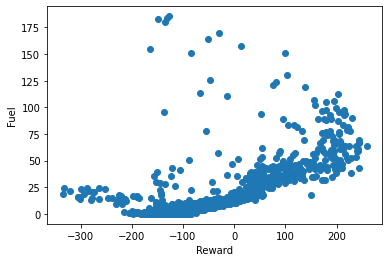

In [50]:
plt.scatter(reward_original, fuel_original)
plt.xlabel("Reward")
plt.ylabel("Fuel")